In [1]:
# Pull the data and create a csv
import pandas as pd
import yfinance as yf
from tabulate import tabulate

# List of specific ticker symbols to check for - Change per your holdings. 
specific_tickers = ['voo', 'voog', 'main', 'amzn', 'googl', 'sdiv', 'schw', 'pmt', 'lcid', 'vz', 'lqd', 'gehc', 'nwl']

# Initialize lists to store data
tickers = []
companies = []
sectors = []
industries = []
countries = []
market_caps = []
pes = []
prices = []
changes = []
volumes = []

# Loop through each ticker symbol
for ticker in specific_tickers:
    # Get Ticker object
    ticker_info = yf.Ticker(ticker)
    
    # Get relevant information
    ticker_info_data = ticker_info.info
    tickers.append(ticker)
    companies.append(ticker_info_data.get('longName', 'N/A'))
    sectors.append(ticker_info_data.get('sector', 'N/A'))
    industries.append(ticker_info_data.get('industry', 'N/A'))
    countries.append(ticker_info_data.get('country', 'N/A'))
    market_caps.append(ticker_info_data.get('marketCap', 'N/A'))
    pes.append(ticker_info_data.get('forwardPE', 'N/A'))
    
    # Fetch historical market data for the last trading day
    hist = ticker_info.history(period='1d')
    if not hist.empty:
        prices.append(hist['Close'].iloc[0])
        changes.append(hist['Close'].iloc[0] - hist['Open'].iloc[0])
        volumes.append(hist['Volume'].iloc[0])
    else:
        prices.append('N/A')
        changes.append('N/A')
        volumes.append('N/A')

# Create a DataFrame to store the collected data
data = {
    'Ticker': tickers,
    'Company': companies,
    'Sector': sectors,
    'Industry': industries,
    'Country': countries,
    'Market Cap': market_caps,
    'P/E': pes,
    'Price': prices,
    'Change': changes,
    'Volume': volumes
}
df = pd.DataFrame(data)

# Print DataFrame
print(tabulate(df, headers='keys', tablefmt='pretty'))

# Save DataFrame to CSV
df.to_csv('stock_data.csv', index=False)

+----+--------+-----------------------------------------------------+------------------------+--------------------------------+---------------+---------------+------------+--------------------+-----------------------+----------+
|    | Ticker |                       Company                       |         Sector         |            Industry            |    Country    |  Market Cap   |    P/E     |       Price        |        Change         |  Volume  |
+----+--------+-----------------------------------------------------+------------------------+--------------------------------+---------------+---------------+------------+--------------------+-----------------------+----------+
| 0  |  voo   |                Vanguard S&P 500 ETF                 |          N/A           |              N/A               |      N/A      |      N/A      |    N/A     | 556.8400268554688  |    0.010009765625     | 1099826  |
| 1  |  voog  |    Vanguard S&P 500 Growth Index Fund ETF Shares    |          N/A  

In [2]:
# Current Byline Sentiment Analysis
from tabulate import tabulate
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from goose3 import Goose
from requests import get
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification
import yfinance as yf
import os

# Function to get the sentiment of financial news articles for a given ticker
def get_ticker_news_sentiment(ticker):
    """
    Returns a Pandas DataFrame of the given ticker's most recent news article headlines,
    with the overall sentiment of each article.

    Args:
        ticker (string)

    Returns:
        pd.DataFrame: {'Date', 'Article title', 'Article sentiment', 'Ticker symbol'}
    """
    ticker_news = yf.Ticker(ticker)
    news_list = ticker_news.get_news()
    extractor = Goose()
    pipe = pipeline("text-classification", model="yiyanghkust/finbert-tone")

    data = []
    for dic in news_list:
        title = dic['title']
        url = dic['link']  # Extract the URL from the dictionary
        response = get(dic['link'])
        article = extractor.extract(raw_html=response.content)
        text = article.cleaned_text
        date = article.publish_date
        if len(text) > 1000:
            data.append({'Ticker': f'{ticker}', 
                         'Date': f'{date}',
                         'Article title': f'{title}',
                         'Article sentiment': 'NaN too long',
                         'Article URL': f'{url}',  # Include the URL in the data
                        })
        else:
            results = pipe(text)
            data.append({'Ticker': f'{ticker}', 
                         'Date': f'{date}',
                         'Article title': f'{title}',
                         'Article sentiment': results[0]['label'],
                         'Article URL': f'{url}',  # Include the URL in the data
                        })
    df = pd.DataFrame(data)
    return df

# Function to generate CSV file for a given ticker
def generate_csv(ticker):
    df = get_ticker_news_sentiment(ticker)
    print(tabulate(df, headers='keys', tablefmt='pretty'))
    df.to_csv(f'out/{ticker}.csv', index=False)

# Read ticker symbols from the output CSV file
output_csv = 'stock_data.csv'
if os.path.exists(output_csv):
    df_output = pd.read_csv(output_csv)
    specific_tickers = df_output['Ticker'].tolist()

    # Generating CSV for each ticker
    for ticker in specific_tickers:
        generate_csv(ticker)
else:
    print(f"Error: Output CSV file '{output_csv}' not found.")

+---+--------+--------------------------+-------------------------------------------------------------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------+
|   | Ticker |           Date           |                                 Article title                                 | Article sentiment |                                                        Article URL                                                        |
+---+--------+--------------------------+-------------------------------------------------------------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------+
| 0 |  voo   |           None           |                European ETF Insights: A Record-Breaking Month                 |     Positive      |             https://finance.yahoo.com/m/c4b6f015-df53-37b4-8

[*********************100%%**********************]  1 of 1 completed


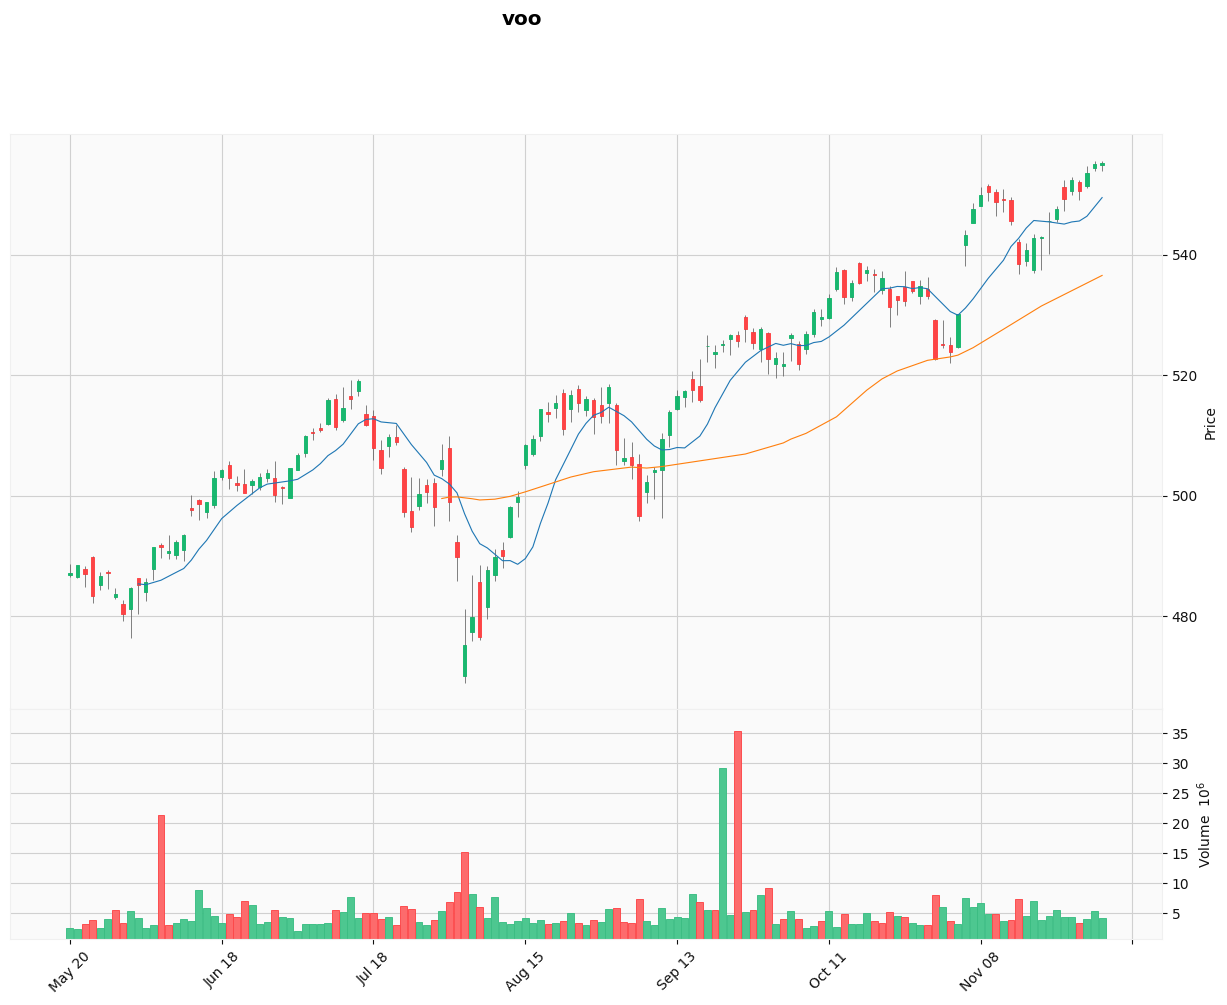

[*********************100%%**********************]  1 of 1 completed


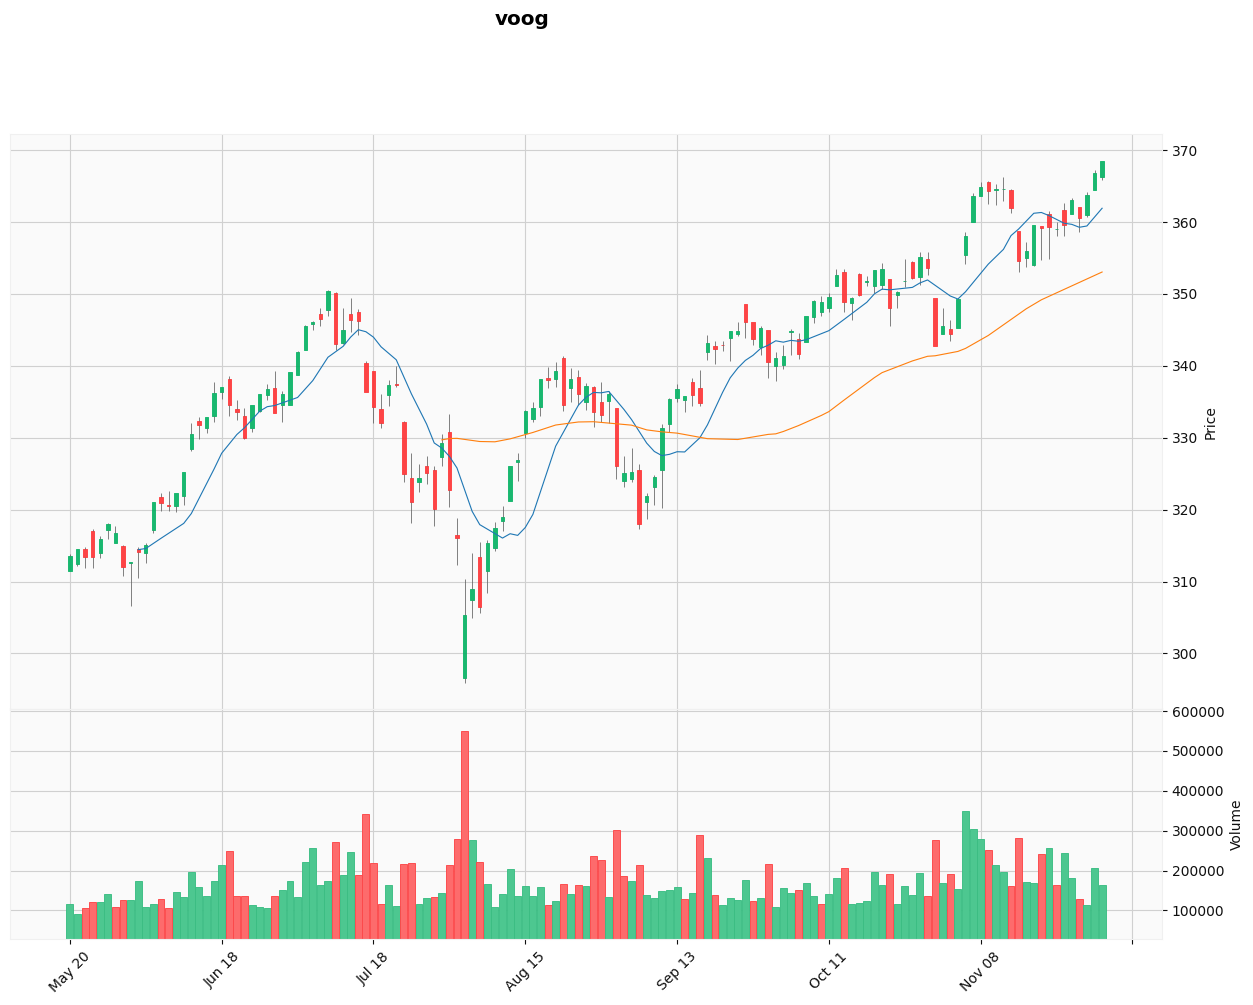

[*********************100%%**********************]  1 of 1 completed


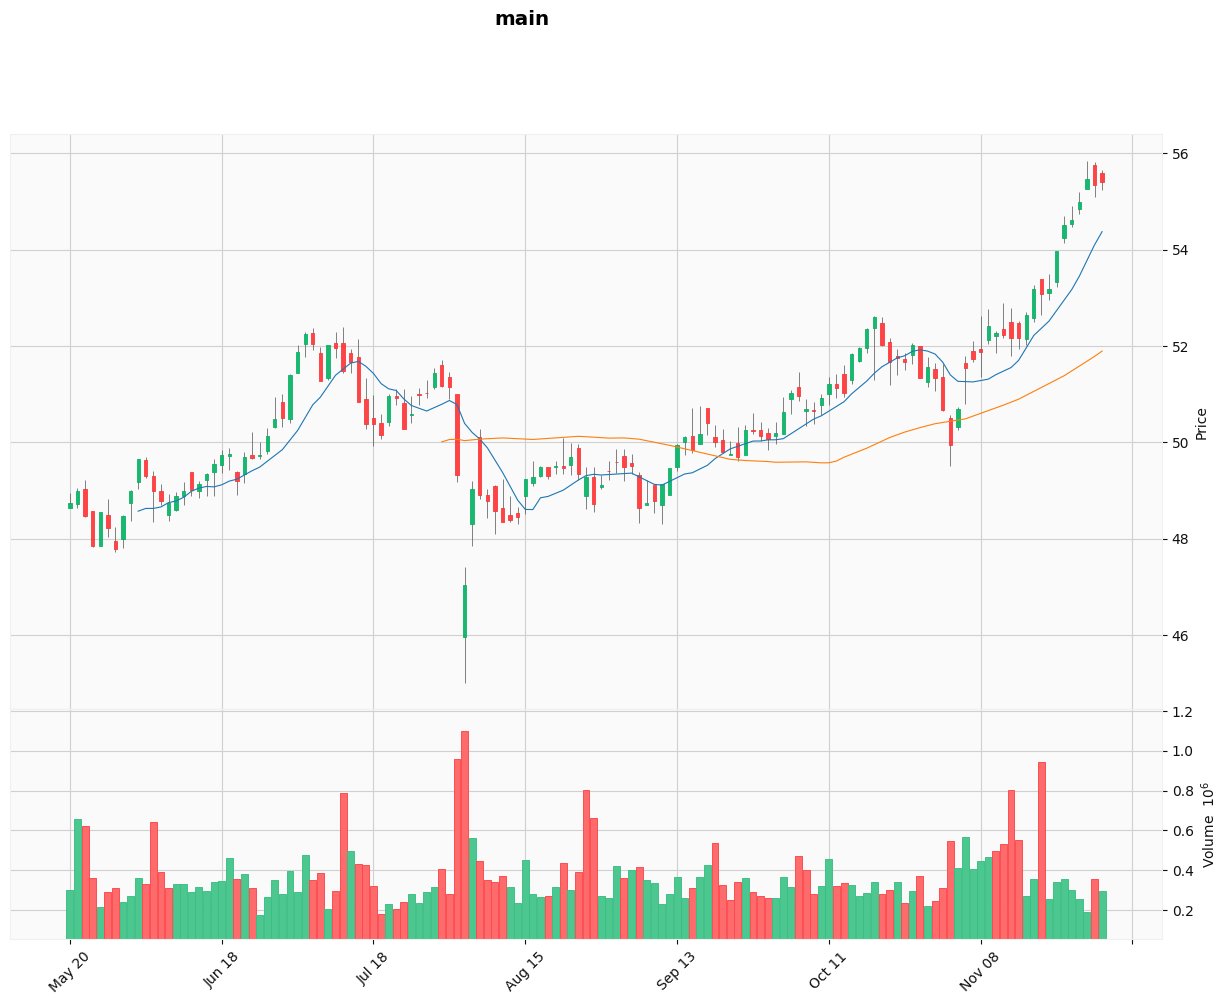

[*********************100%%**********************]  1 of 1 completed


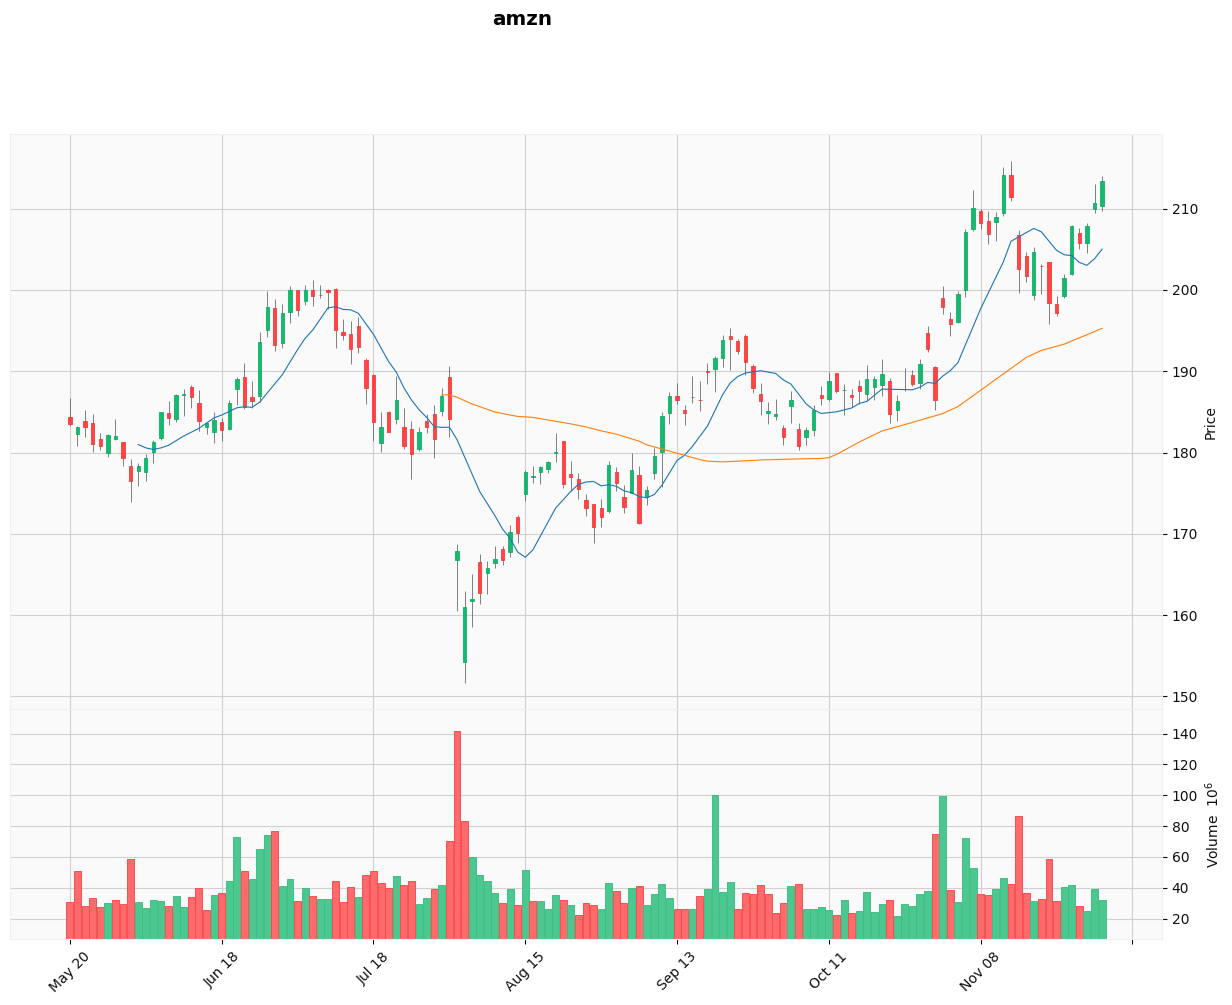

[*********************100%%**********************]  1 of 1 completed


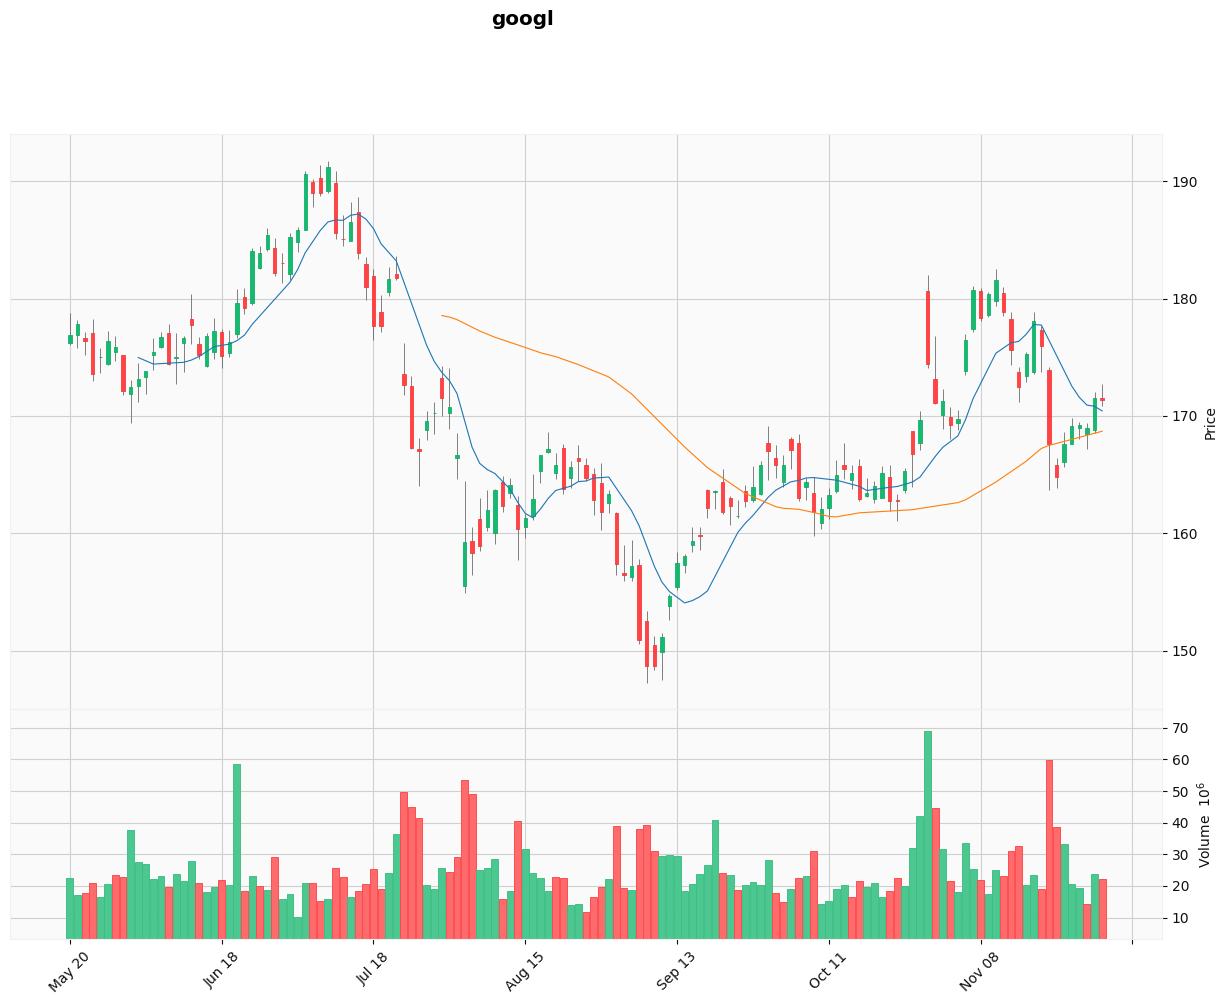

[*********************100%%**********************]  1 of 1 completed


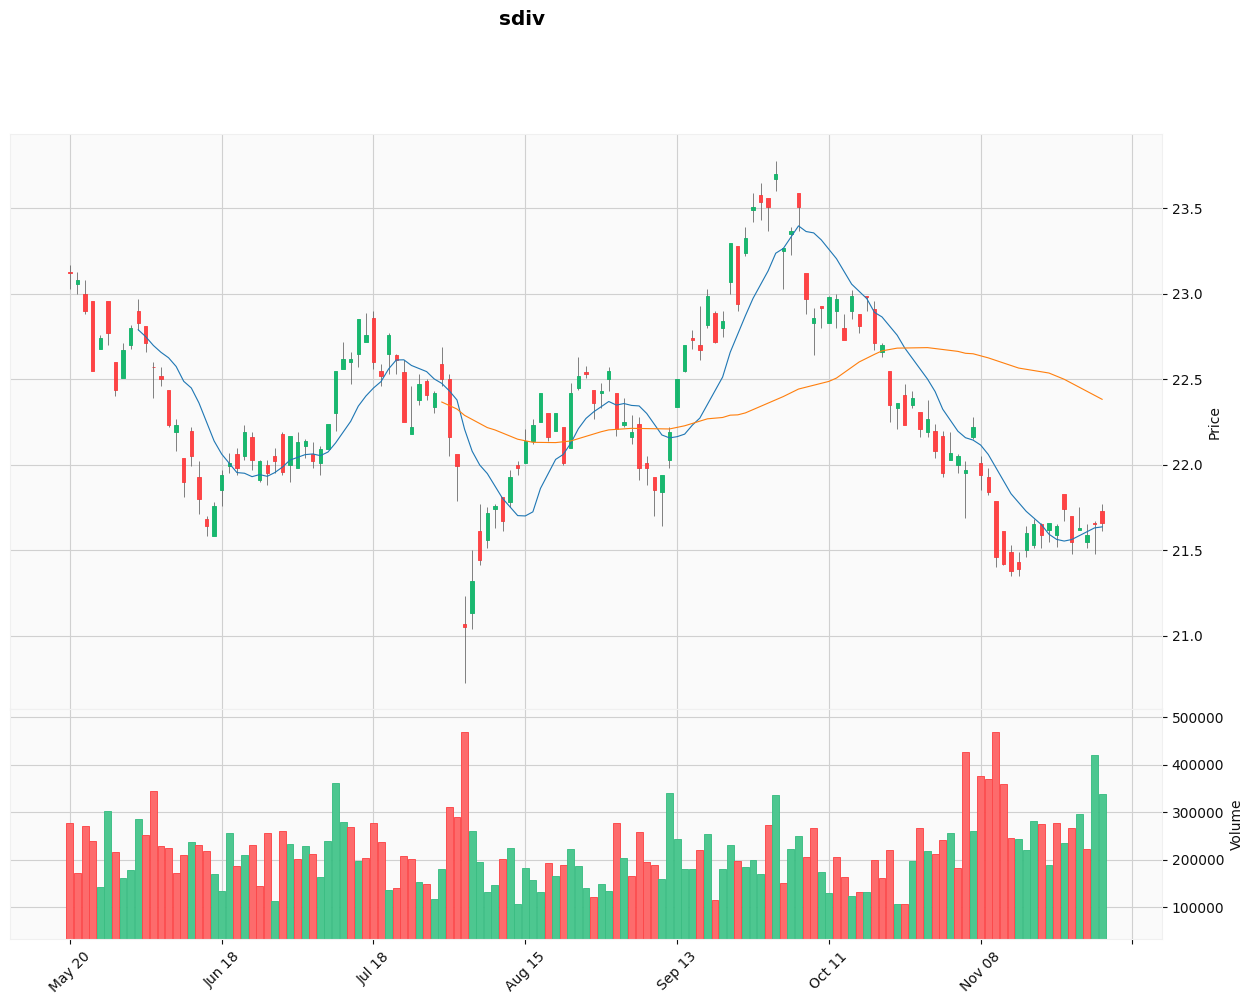

[*********************100%%**********************]  1 of 1 completed


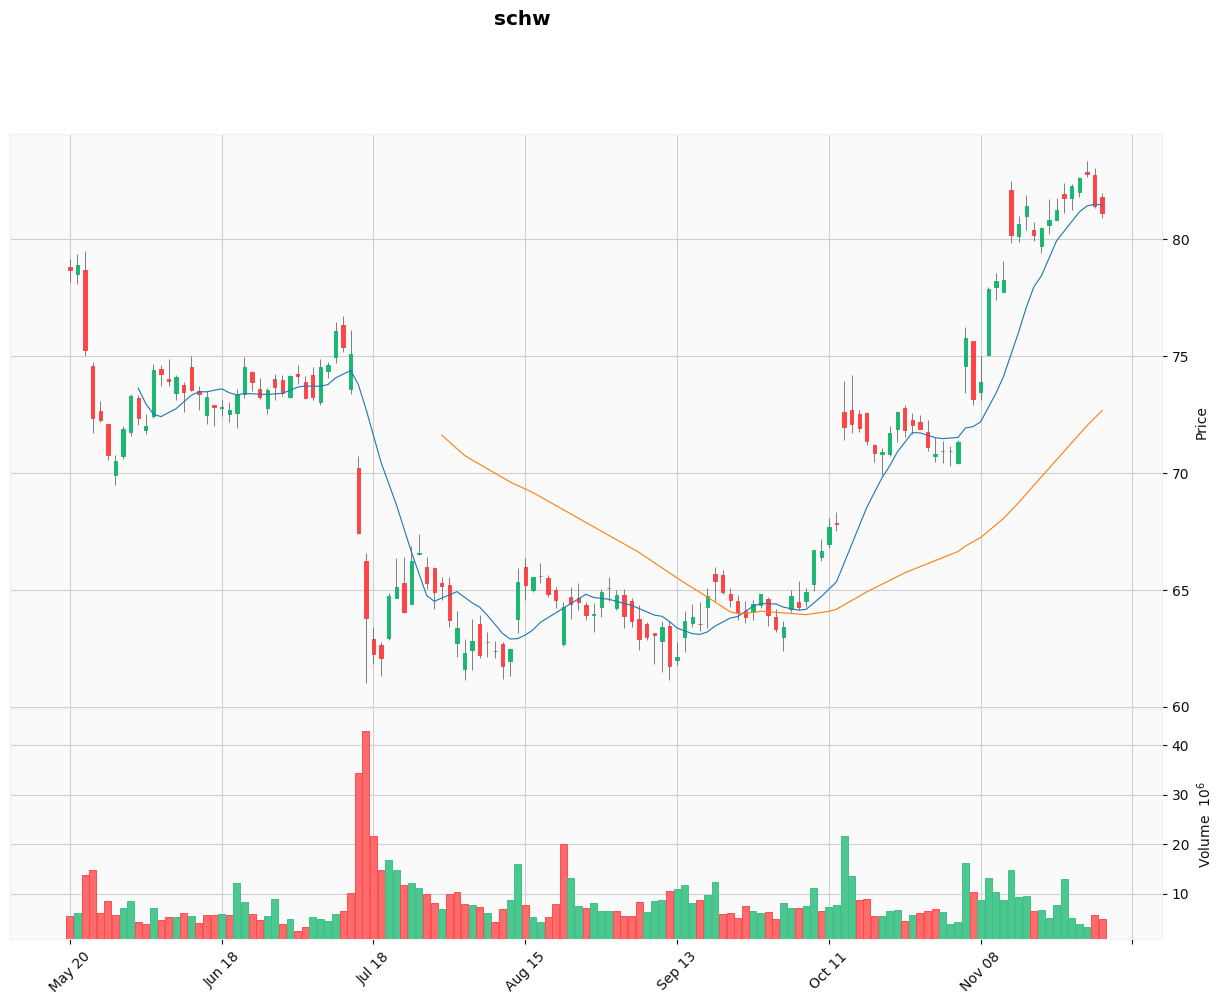

[*********************100%%**********************]  1 of 1 completed


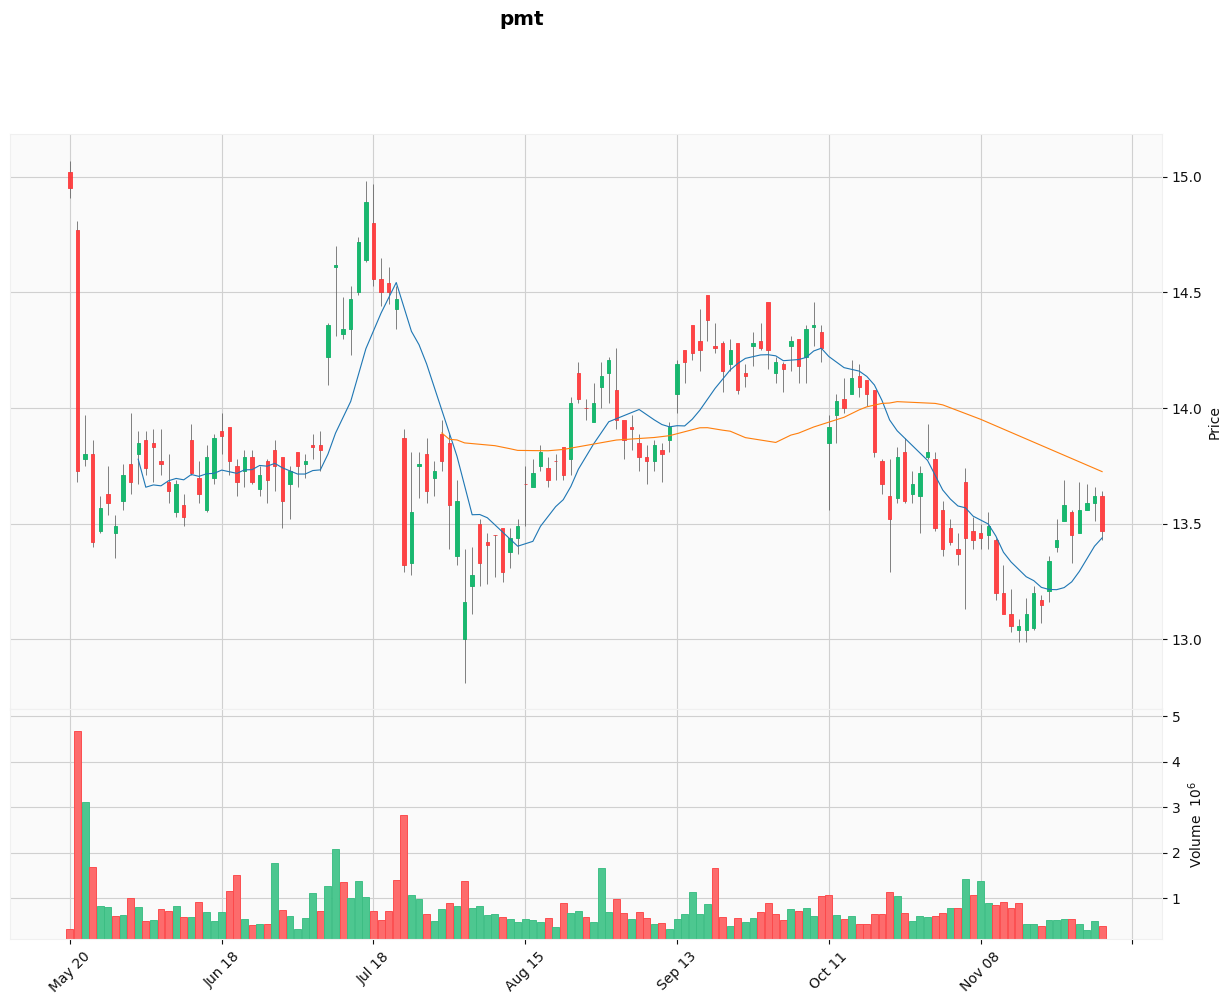

[*********************100%%**********************]  1 of 1 completed


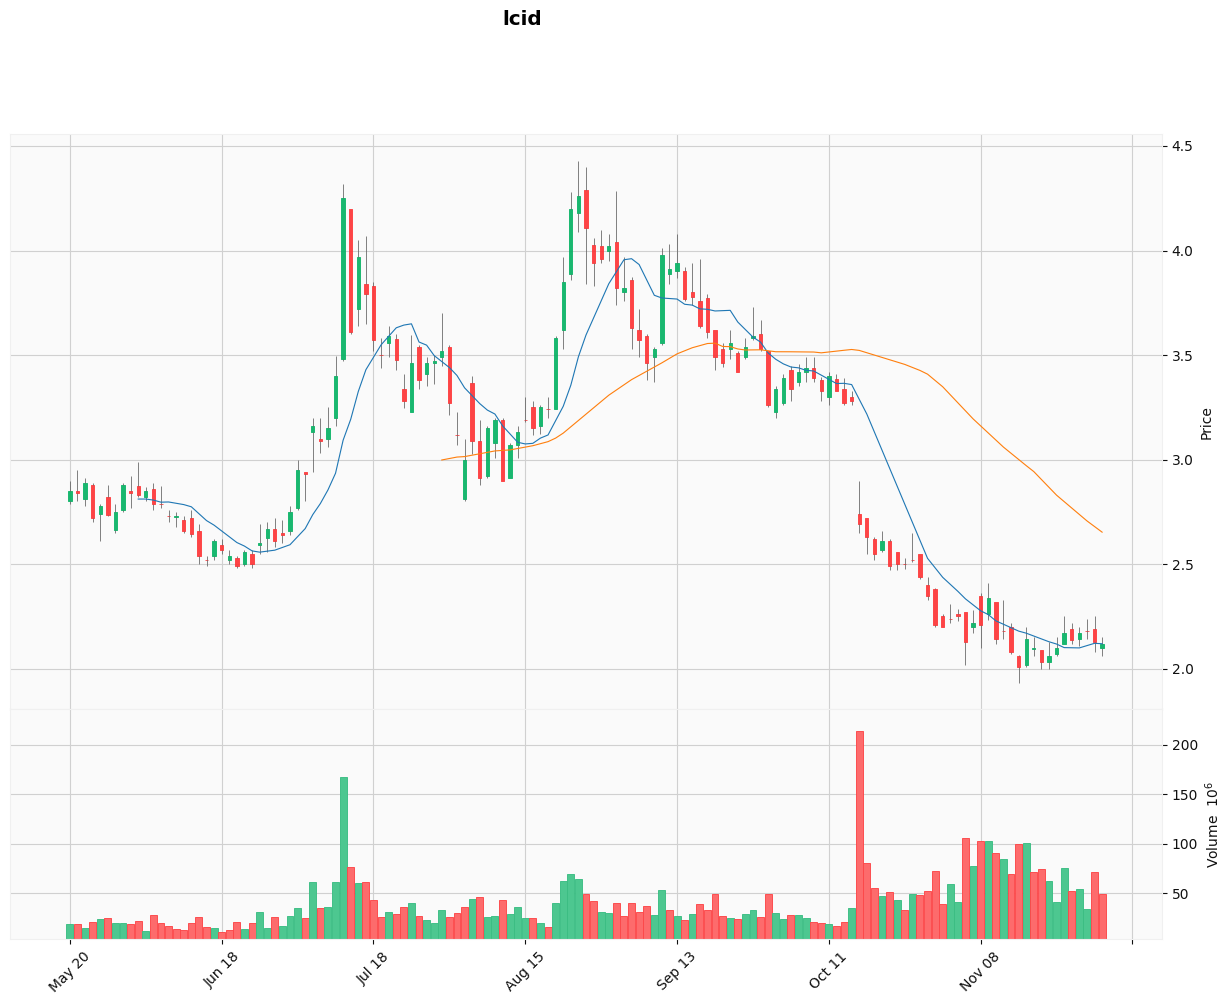

[*********************100%%**********************]  1 of 1 completed


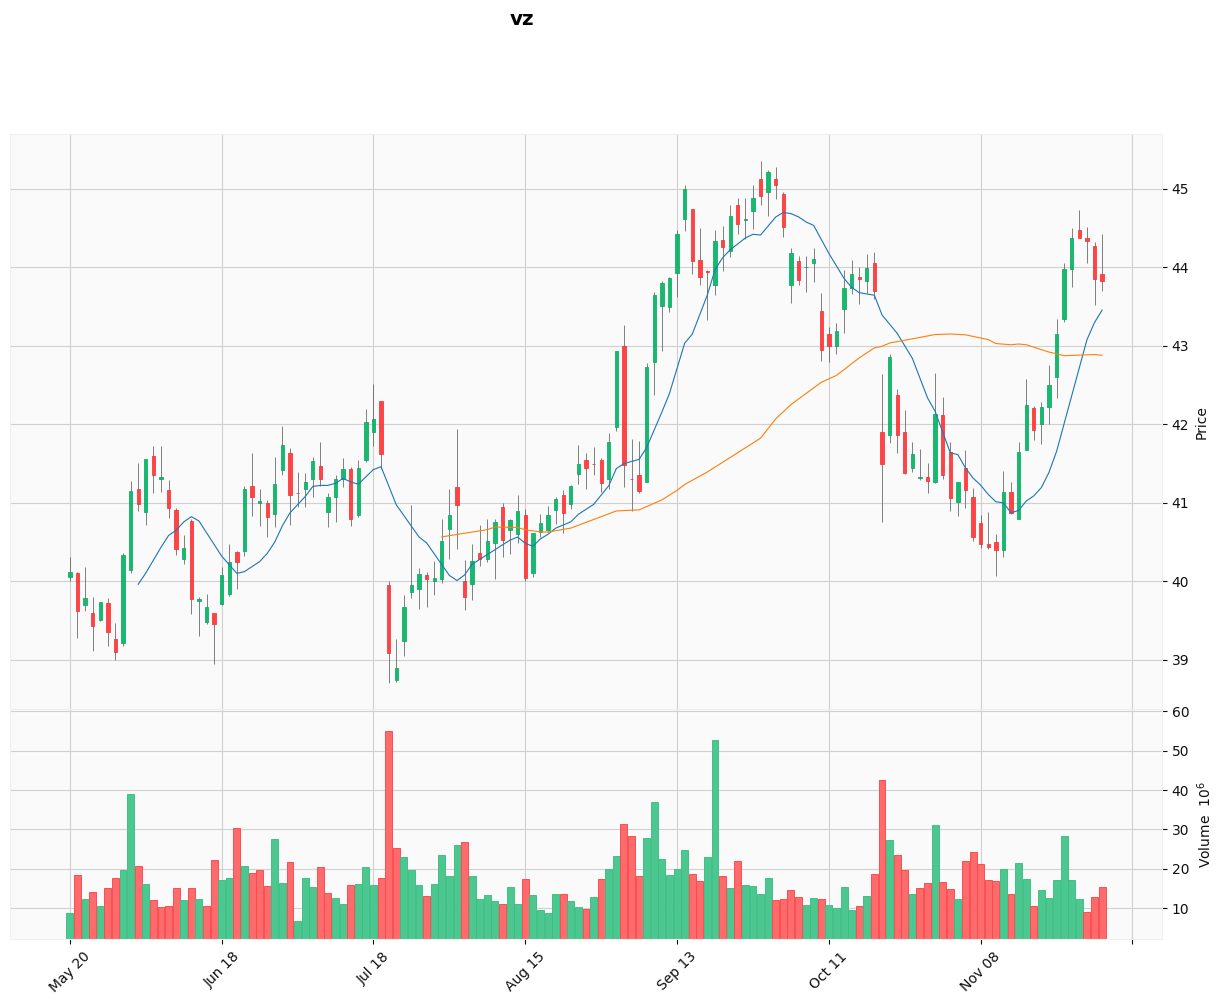

[*********************100%%**********************]  1 of 1 completed


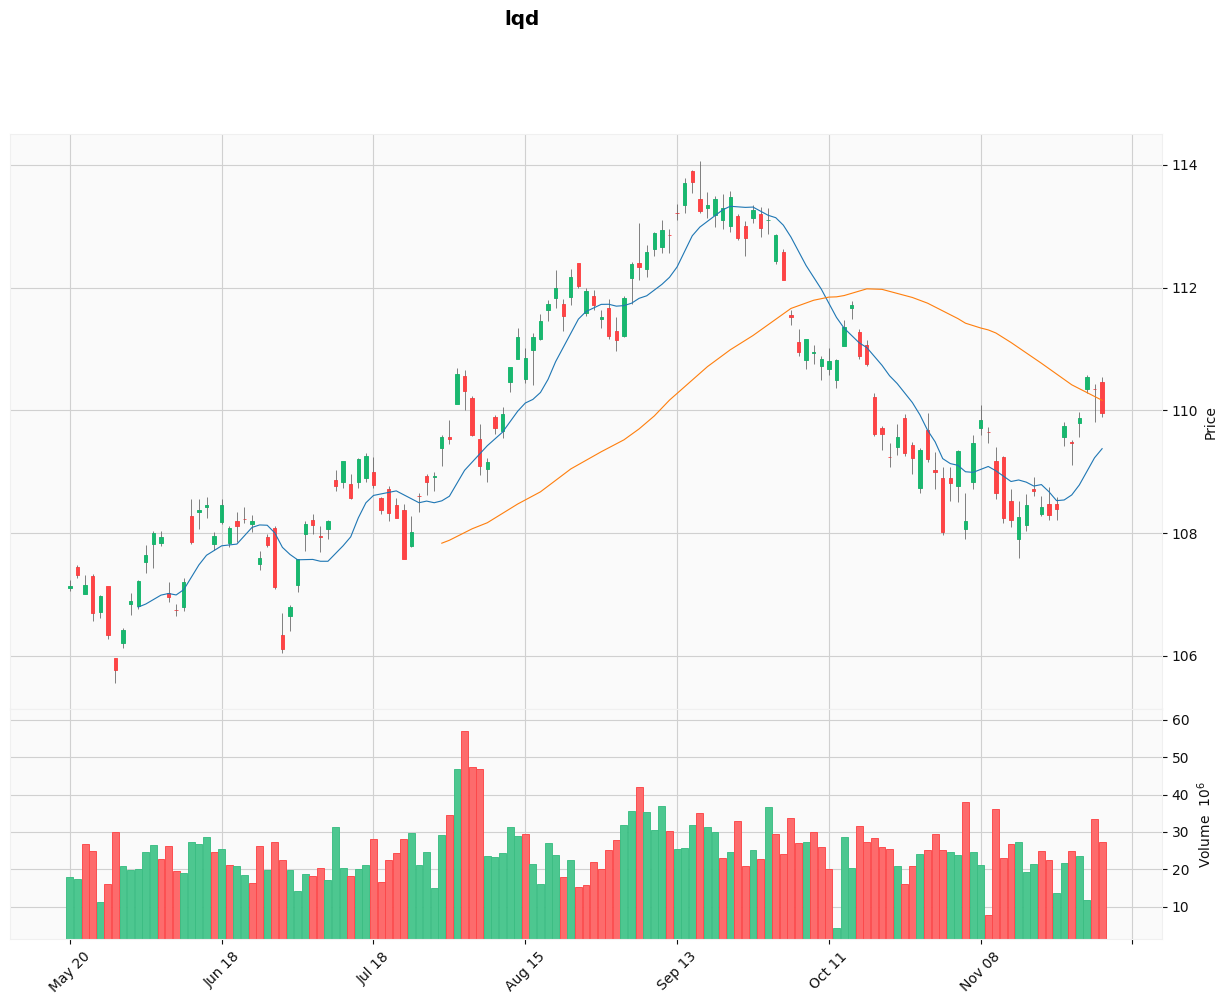

[*********************100%%**********************]  1 of 1 completed


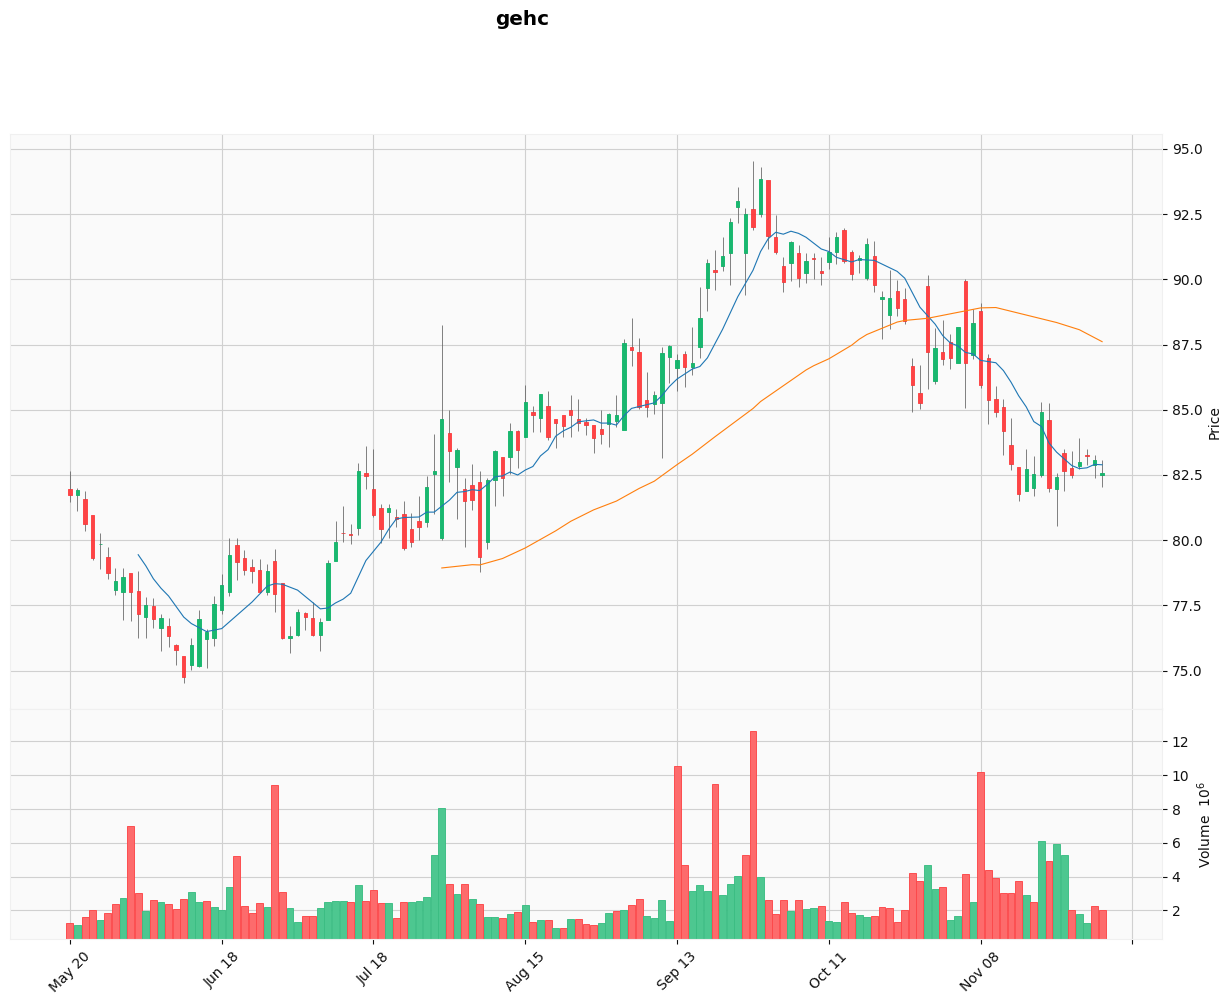

[*********************100%%**********************]  1 of 1 completed


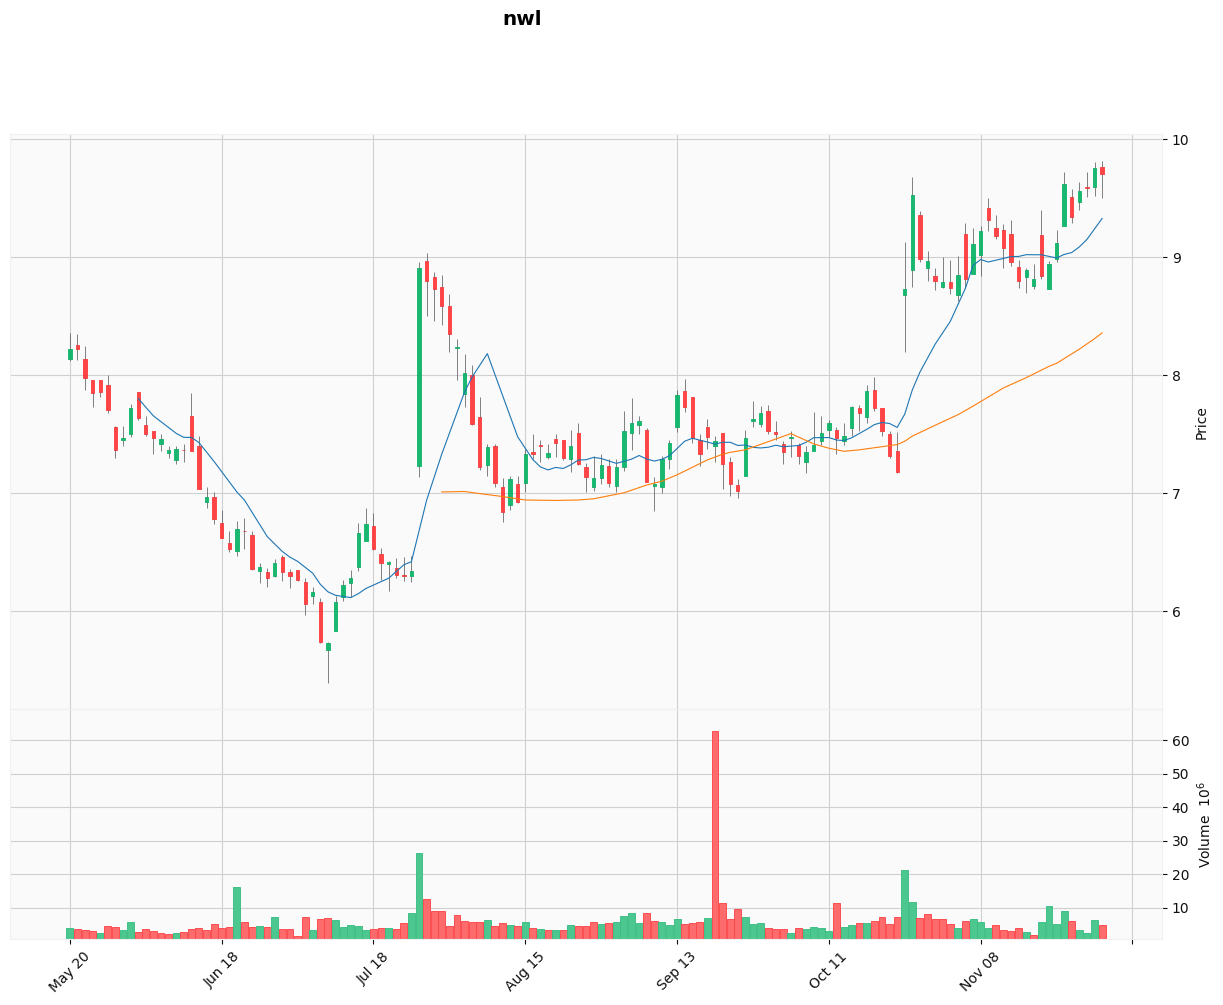

In [3]:
# 180 day Share Price PLUS 10 day and 50 day Moving Average charts
import datetime
import pandas as pd
import yfinance as yf
import mplfinance as mpf
#specific_tickers
def plot_line_chart(data, ticker_symbol):
    # Plot line chart
    mpf.plot(data, type='candle',mav=(10, 50), style='yahoo', title=ticker_symbol, figscale=2, volume=True)

# Read overview.csv into DataFrame
df = pd.read_csv('stock_data.csv')

# Extract tickers from the 'Ticker' column
tickers = df['Ticker']
company = df['Company']

# Iterate through each stock ticker in the DataFrame
for ticker_symbol in tickers:
    # Calculate start date as 180 days before the current date
    end_date = datetime.datetime.now().date()
    start_date = end_date - datetime.timedelta(days=200)
    
    # Get historical stock price data
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    
    # Plot line chart for each stock
    plot_line_chart(data, ticker_symbol)



In [4]:
# Analyst Recommendations 

# Import necessary libraries
import pandas as pd
import numpy as np
from tradingview_ta import TA_Handler, Interval, Exchange
import yfinance as yf
import mplfinance as mpf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

us_exchanges = ["NYSE", "NASDAQ", "AMEX", "CHX", "BZX", "BX", "PHLX", "PSX"]

# Read overview.csv into DataFrame
df = pd.read_csv('stock_data.csv')

# Extract tickers from the 'Ticker' column
tickers = df['Ticker']

tickers_data = []

# Iterate through each ticker
for ticker in tickers:
    found_data = False
    
    # Iterate through each US exchange
    for exchange in us_exchanges:
        try:
            # Retrieve data for the ticker from the current exchange
            data = TA_Handler(
                symbol=ticker,
                screener="america",
                exchange=exchange,
                interval="1d"
            )
            data = data.get_analysis().summary
            tickers_data.append(data)
            
            # If data is found, set found_data to True and break out of the loop
            found_data = True
            break

        except Exception as e:
            # Print error message if no data is found for the ticker on the current exchange
            print(f"No data found for ticker {ticker} in {exchange}. Error: {e}")

    
    # If data is not found for any exchange, print a message
    if not found_data:
        print(f"No data found for ticker {ticker} on any US exchange.")

print("Data successfully imported.")

recommendations = []
buys = []
sells = []
neutrals = []

# Iterate through each data in tickers_data
for data in tickers_data:
    recommendation = data.get('RECOMMENDATION')
    buy = data.get('BUY')
    sell = data.get('SELL')
    neutral = data.get('NEUTRAL')
    
    recommendations.append(recommendation)
    buys.append(buy)
    sells.append(sell)
    neutrals.append(neutral)

data = {
    'Ticker': tickers,
    'Recommendations': recommendations,
    'Buys': buys,
    'Sells': sells,
    'Neutrals': neutrals
}

df = pd.DataFrame(data)
# Define the order of categories
order_categories = {
    'STRONG_BUY': 5,
    'BUY': 4,
    'NEUTRAL': 3,
    'SELL': 2,
    'STRONG_SELL': 1
}

# Assign a numerical value to each category in a new column "Order"
df['Order'] = df['Recommendations'].map(order_categories)
df = df.sort_values('Order', ascending=True).reset_index(drop=True)

# Drop the "Order" column if not needed in the final output
df = df.drop('Order', axis=1)

# Display the sorted dataframe
df


No data found for ticker voo in NYSE. Error: Exchange or symbol not found.
No data found for ticker voo in NASDAQ. Error: Exchange or symbol not found.
No data found for ticker voog in NYSE. Error: Exchange or symbol not found.
No data found for ticker voog in NASDAQ. Error: Exchange or symbol not found.
No data found for ticker amzn in NYSE. Error: Exchange or symbol not found.
No data found for ticker googl in NYSE. Error: Exchange or symbol not found.
No data found for ticker sdiv in NYSE. Error: Exchange or symbol not found.
No data found for ticker sdiv in NASDAQ. Error: Exchange or symbol not found.
No data found for ticker lcid in NYSE. Error: Exchange or symbol not found.
No data found for ticker lqd in NYSE. Error: Exchange or symbol not found.
No data found for ticker lqd in NASDAQ. Error: Exchange or symbol not found.
No data found for ticker gehc in NYSE. Error: Exchange or symbol not found.
No data found for ticker nwl in NYSE. Error: Exchange or symbol not found.
Data suc

Ticker Recommendations  Buys  Sells  Neutrals
0    sdiv            SELL     1     15        10
1    lcid            SELL     2     14        10
2    gehc            SELL     4     12        10
3     pmt         NEUTRAL     8      9         9
4     voo             BUY    14      2        10
5    voog             BUY    15      2         9
6    main             BUY    14      3         9
7   googl             BUY    12      4        10
8    schw             BUY    12      4        10
9      vz             BUY    12      4        10
10    lqd             BUY    12      4        10
11    nwl             BUY    15      3         8
12   amzn      STRONG_BUY    17      0         9

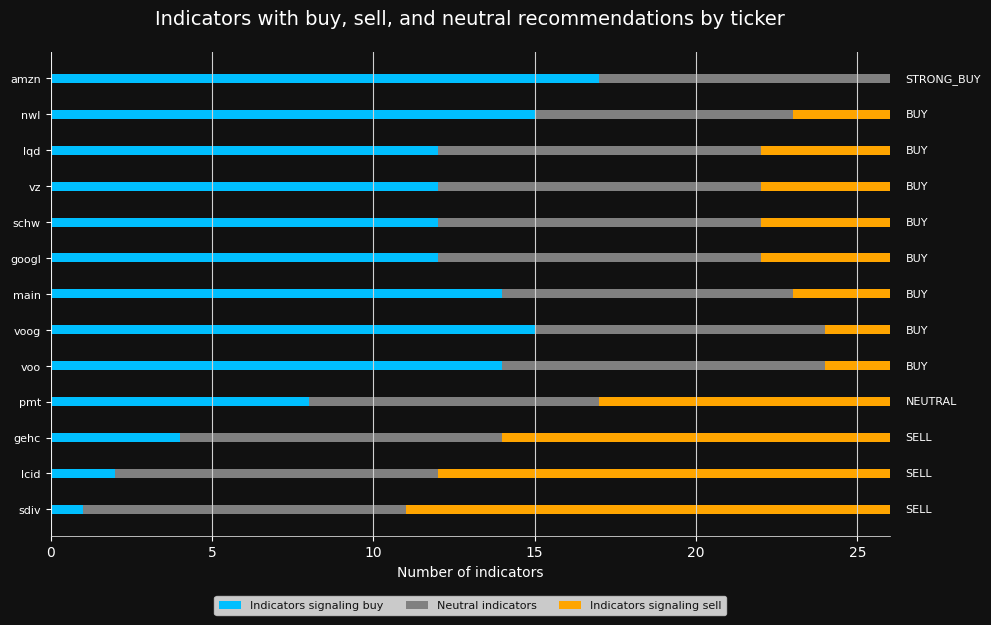

In [5]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#111111')
ax.set_facecolor('#111111')

# Add the horizontal bars for buys, neutrals, and sells
ax.barh(df.index, df["Buys"], height=0.25, color='#00BFFF', label='Indicators signaling buy')
ax.barh(df.index, df["Neutrals"], height=0.25, color='#808080', label='Neutral indicators', left=df["Buys"])
ax.barh(df.index, df["Sells"], height=0.25, color='#FFA500', label='Indicators signaling sell', left=df["Buys"] + df["Neutrals"])

# Set the axes labels
ax.set_yticks(df.index)
ax.set_yticklabels(df["Ticker"], fontsize=8, color='white')
ax.set_xlabel('Number of indicators', fontsize=10, color='white')

# Add title with larger font size and additional spacing
ax.set_title('Indicators with buy, sell, and neutral recommendations by ticker', fontsize=14, color='white', pad=20)

# Add the annotations
for i, recommendation in enumerate(df["Recommendations"]):
    ax.annotate(recommendation, xy=(25, i), xytext=(26.5, i),
                color='white', fontsize=8, va='center', ha='left')

# Remove the horizontal grid lines
ax.yaxis.grid(False)

# Configure the tick and axis styles
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust the spacing
plt.tight_layout()

# Set the text color of the legend to white
legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.175), ncol=3, fontsize=8)
for text in legend.get_texts():
    text.set_color('#111111')

# Display the plot
plt.show()

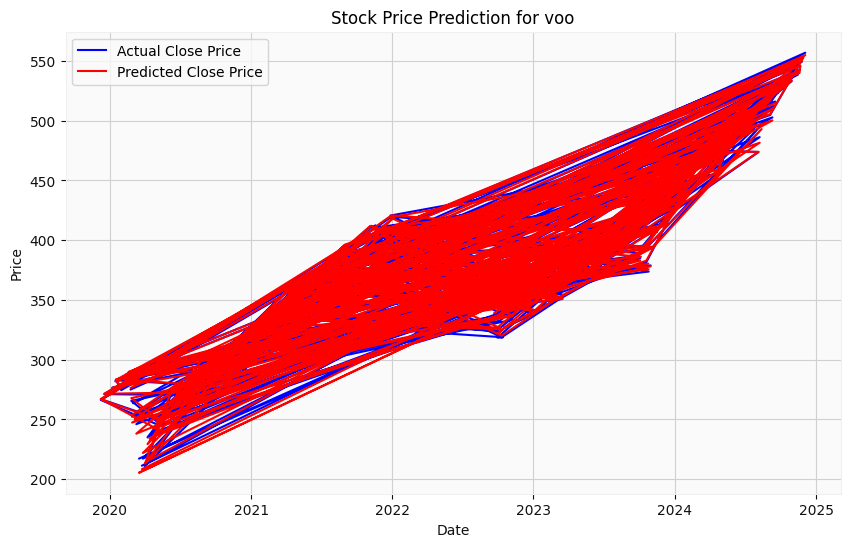

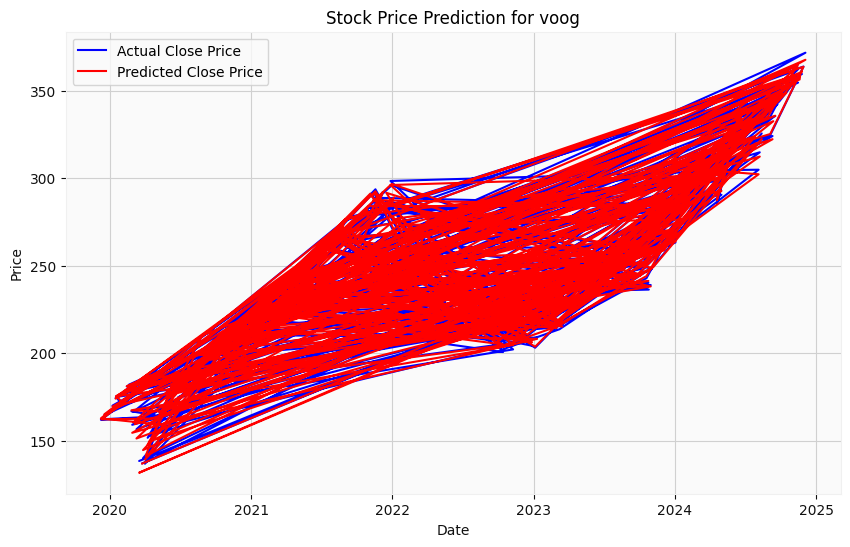

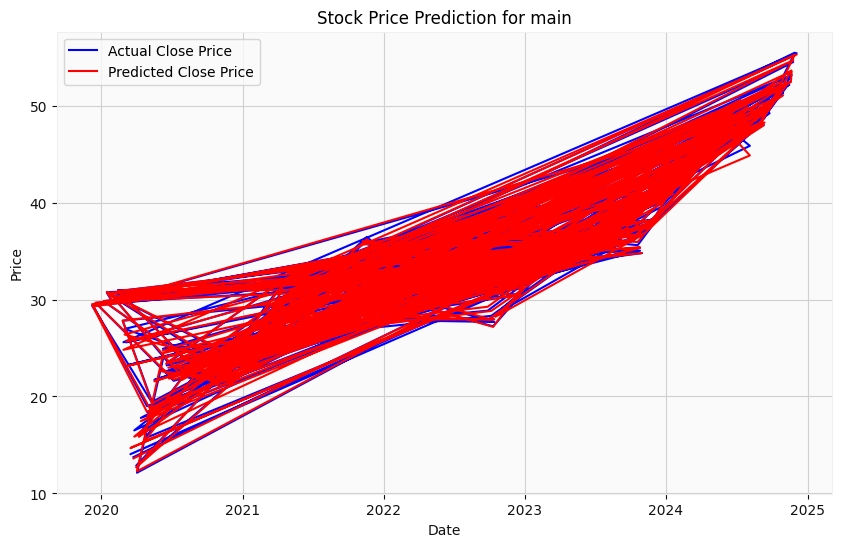

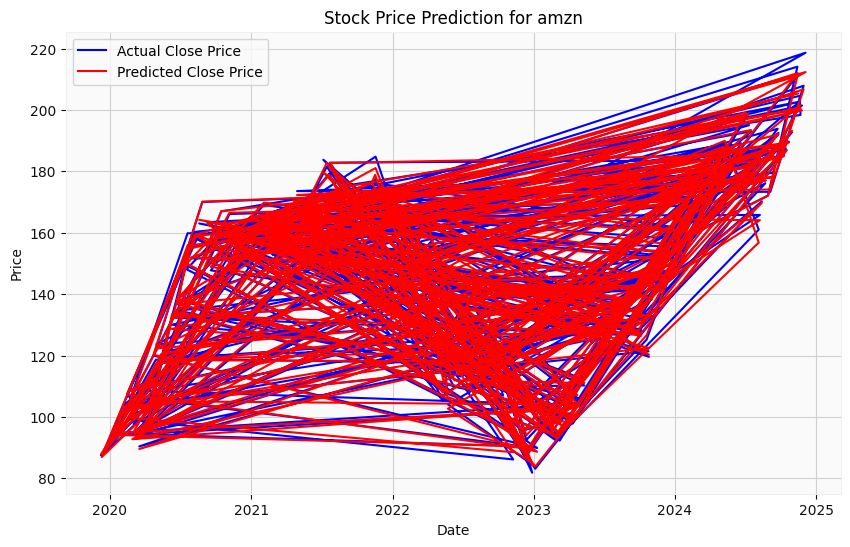

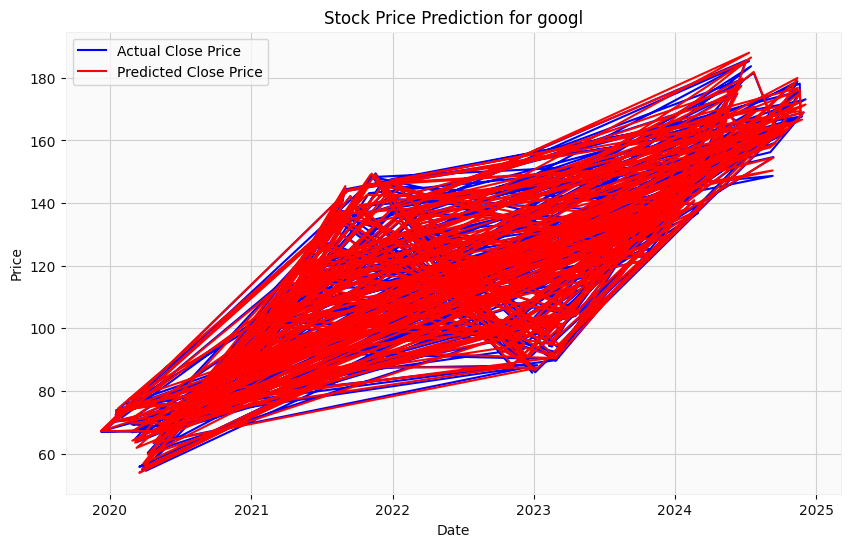

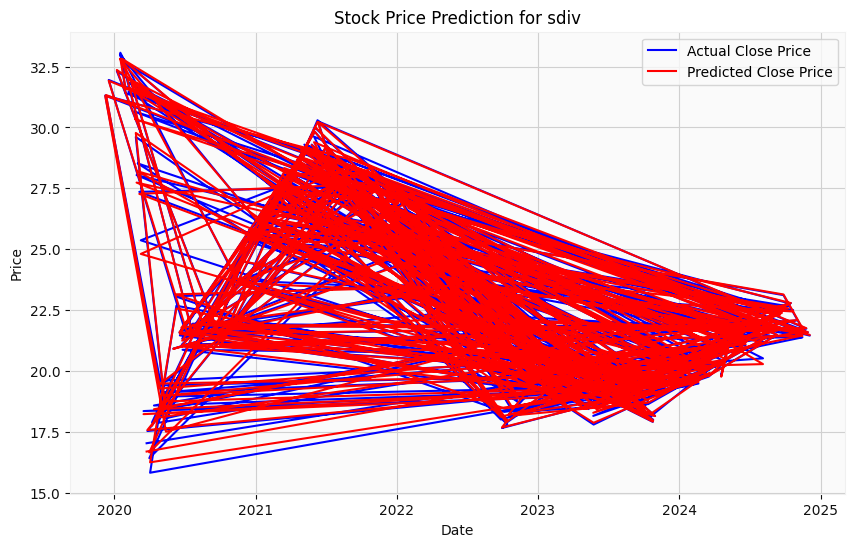

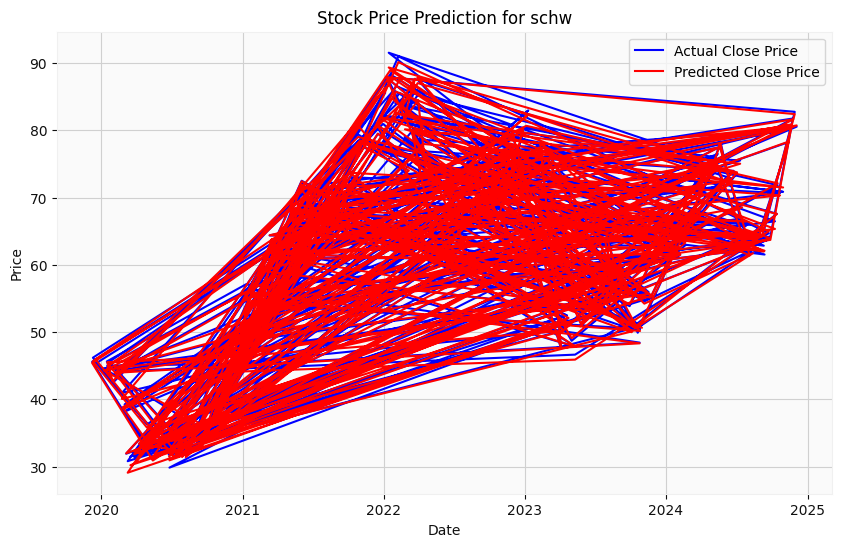

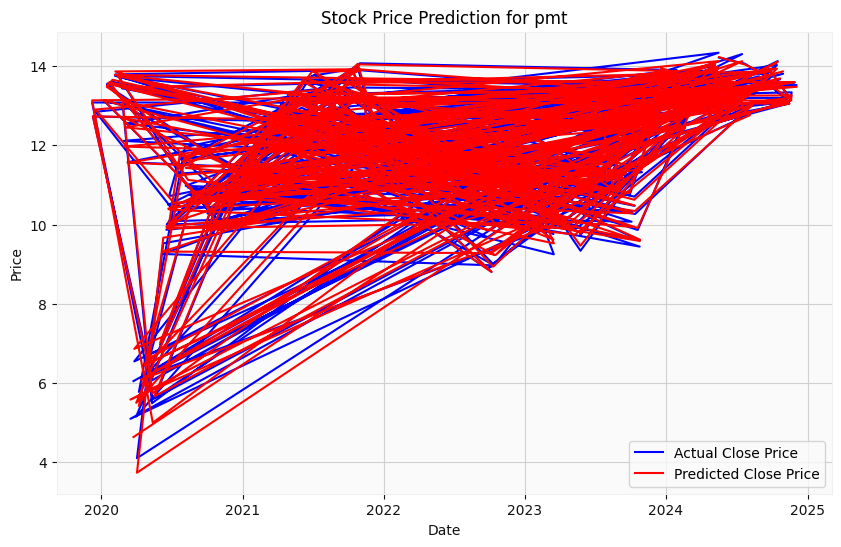

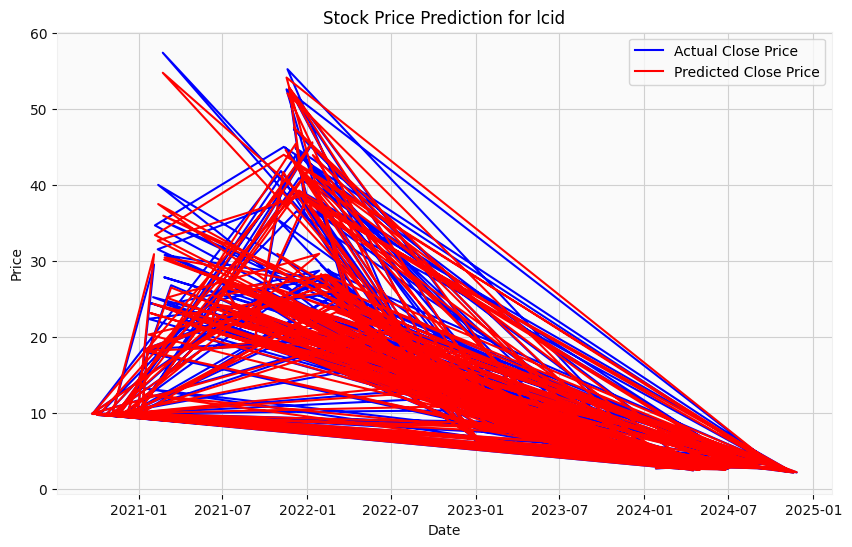

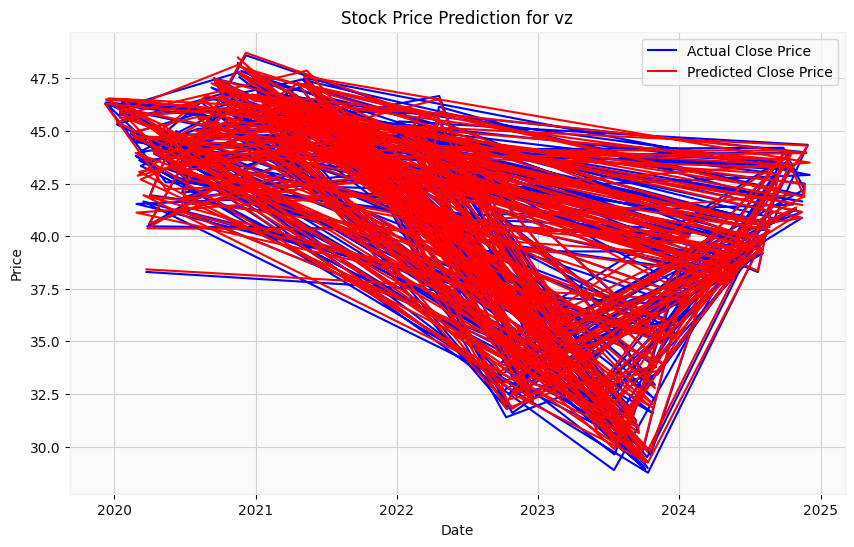

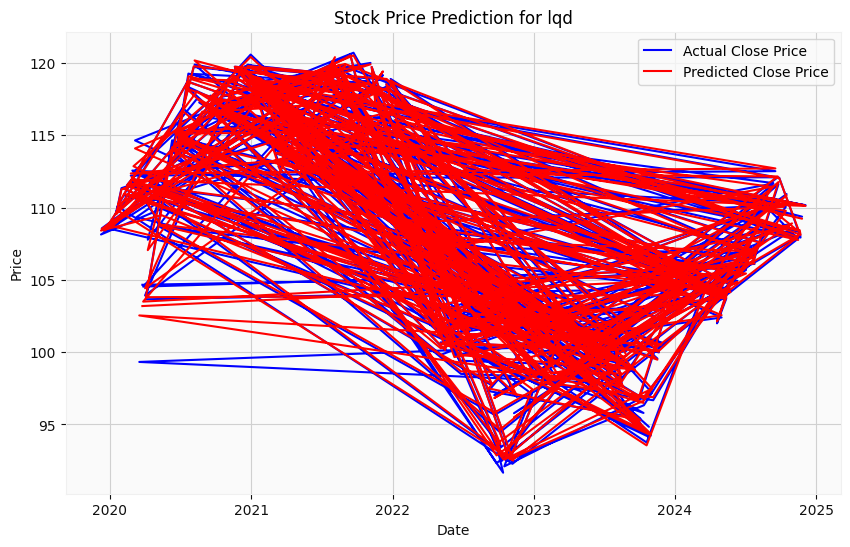

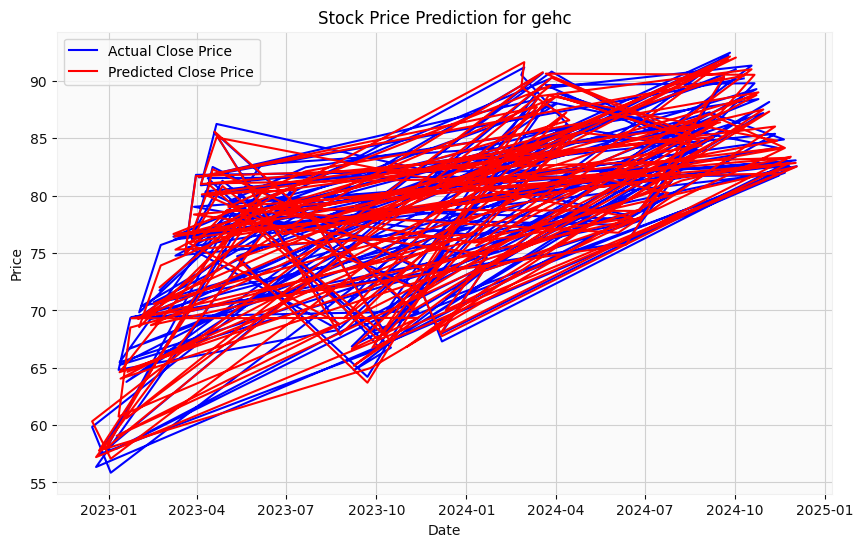

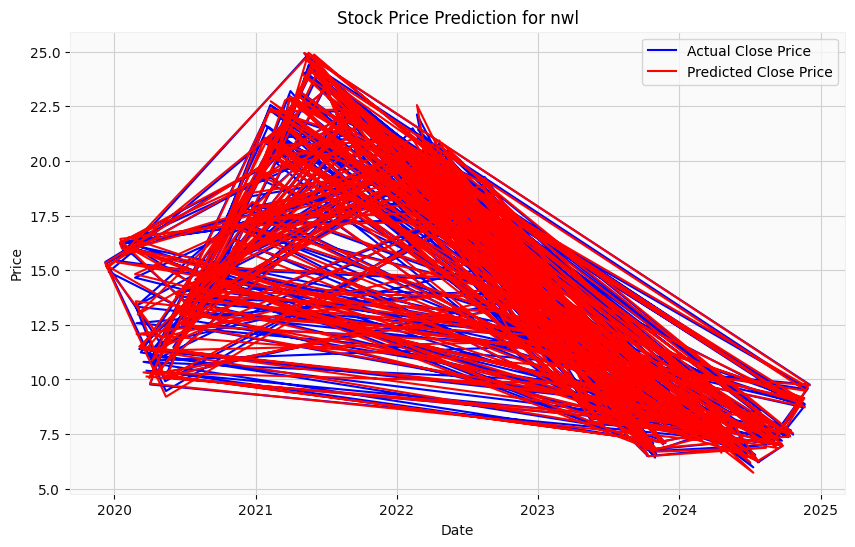

Mean Squared Error for voo: 4.672819861755046
Mean Squared Error for voog: 3.3067508238959697
Mean Squared Error for main: 0.06888215076410249
Mean Squared Error for amzn: 2.133352600896426
Mean Squared Error for googl: 1.2793234902276067
Mean Squared Error for sdiv: 0.01467375682642621
Mean Squared Error for schw: 0.5399416074369038
Mean Squared Error for pmt: 0.02089698146852437
Mean Squared Error for lcid: 0.454023356339877
Mean Squared Error for vz: 0.06679896068722162
Mean Squared Error for lqd: 0.09860487304567198
Mean Squared Error for gehc: 0.6835793693073423
Mean Squared Error for nwl: 0.03615548837453497
   Ticker 15 Days Projection 30 Days Projection 60 Days Projection
0     voo               None               None               None
1    voog               None               None               None
2    main               None               None               None
3    amzn               None               None               None
4   googl               None               

In [6]:
# Machine Learning 15, 30, 60 day Prdictions

import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Read stock_data.csv into DataFrame
df = pd.read_csv('stock_data.csv')

# Extract tickers from the 'Ticker' column
tickers = df['Ticker']

# List to store data for all tickers
tickers_data = []

# List to store MSE for each ticker
mse_list = []

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)

    # Get historical market data for the past month
    hist = ticker.history(period="60mo")

    # Append the historical data to the list
    tickers_data.append(hist)

    # Select relevant features and target variable
    features = ['Open', 'High', 'Low', 'Volume']  # You can modify these features as needed
    
    # Drop rows with missing values
    hist = hist.dropna()

    # Split the data into features (X) and target variable (y)
    X = hist[features]
    y = hist['Close']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a Random Forest regressor
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    predictions = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mse_list.append(mse)

    # Plot predicted vs. actual prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Close Price', color='blue')
    plt.plot(y_test.index, predictions, label='Predicted Close Price', color='red')
    plt.title(f'Stock Price Prediction for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Print MSE for each ticker
for ticker_symbol, mse in zip(tickers, mse_list):
    print(f'Mean Squared Error for {ticker_symbol}: {mse}')

# List to store projected prices for each ticker
projected_prices = []

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)
    
    # Get historical market data for the past month
    hist = ticker.history(period="3mo")
    
    # Select relevant features
    features = ['Open', 'High', 'Low', 'Volume']  # You can modify these features as needed
    
    # Drop rows with missing values
    hist = hist.dropna()
    
    # If there is enough data for predictions
    if len(hist) > 60:  # Assuming at least 60 days of historical data is required
        
        # Split the data into features (X) and target variable (y)
        X = hist[features]
        y = hist['Close']
        
        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Train a Random Forest regressor
        model = RandomForestRegressor(n_estimators=150, random_state=42)
        model.fit(X_scaled, y)
        
        # Get the most recent date in the historical data
        most_recent_date = hist.index[-1]
        
        # Projected dates for 15, 30, and 60 days in the future
        future_dates = [most_recent_date + timedelta(days=15),
                        most_recent_date + timedelta(days=30),
                        most_recent_date + timedelta(days=60)]
        
        # Predict prices for future dates
        future_prices = []
        for date in future_dates:
            # Check if the desired date exists in the historical data
            if date in hist.index:
                # Create features for the future date
                future_features = hist.loc[date][features]
                
                # Standardize the features using the same scaler
                future_features_scaled = scaler.transform([future_features])
                
                # Predict the price for the future date
                future_price = model.predict(future_features_scaled)[0]
                future_prices.append(future_price)
            else:
                # If the desired date doesn't exist, skip prediction
                future_prices.append(None)
        
        # Store the projected prices for the current ticker
        projected_prices.append({
            'Ticker': ticker_symbol,
            '15 Days Projection': future_prices[0],
            '30 Days Projection': future_prices[1],
            '60 Days Projection': future_prices[2]
        })
    else:
        # If there is not enough data for predictions, fill with None
        projected_prices.append({
            'Ticker': ticker_symbol,
            '15 Days Projection': None,
            '30 Days Projection': None,
            '60 Days Projection': None
        })

# Create a DataFrame from the projected prices
projected_prices_df = pd.DataFrame(projected_prices)

# Print the projected prices table
print(projected_prices_df)

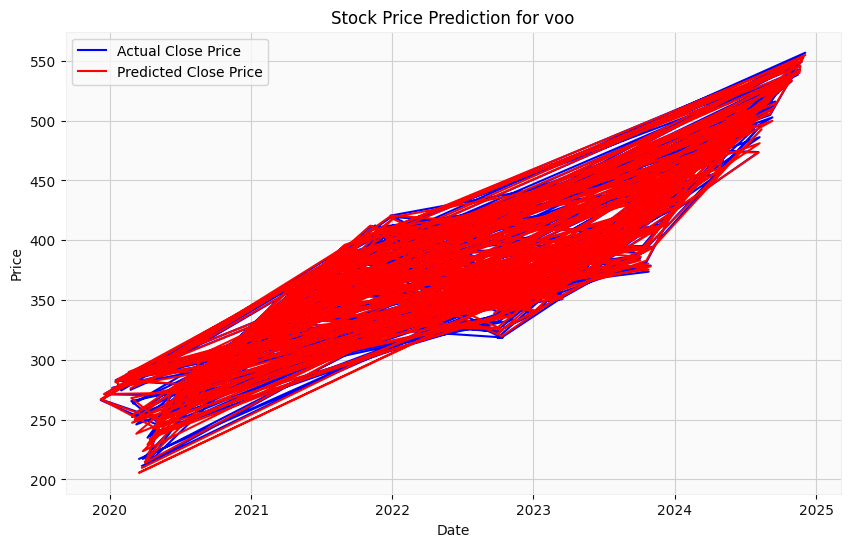

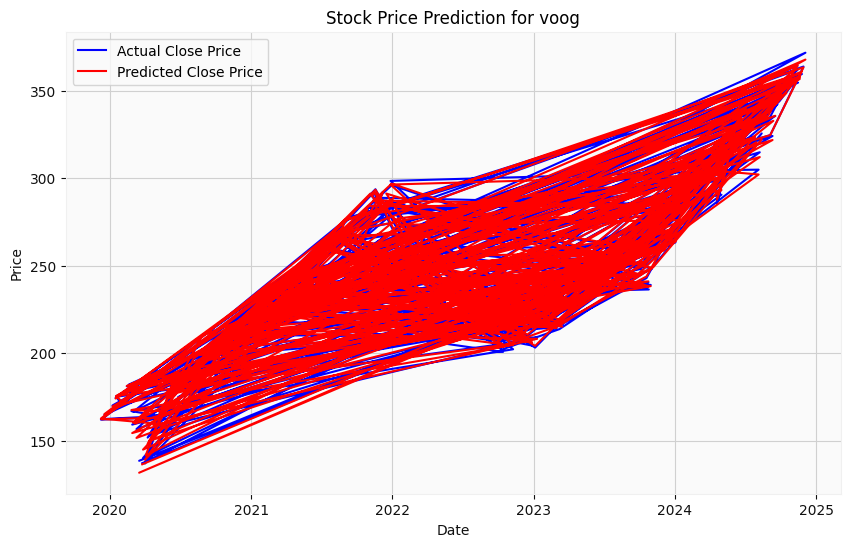

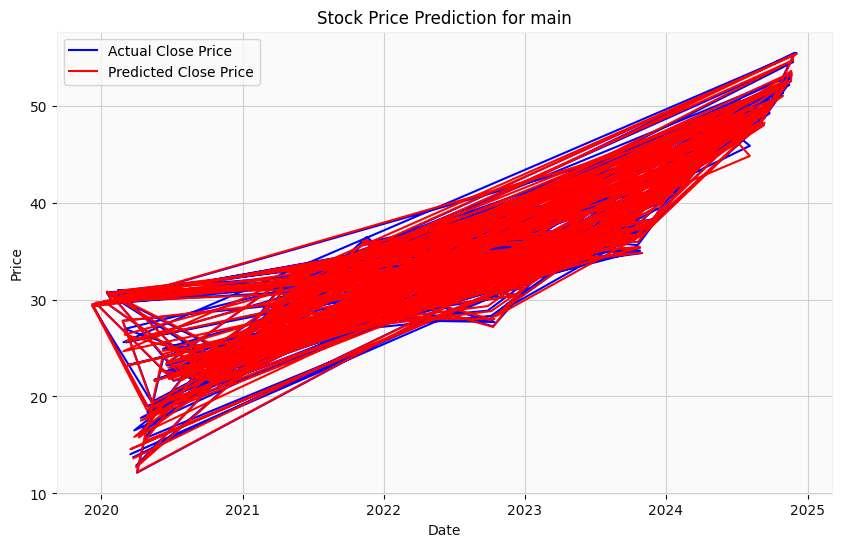

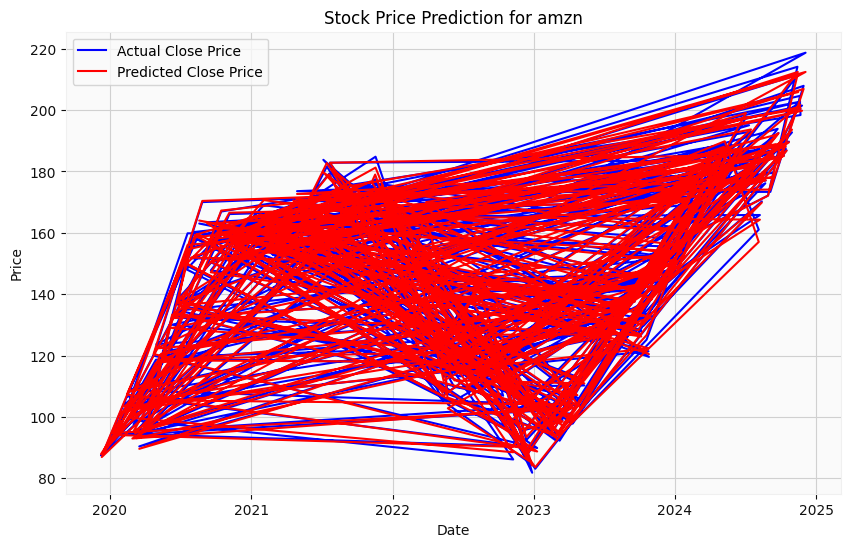

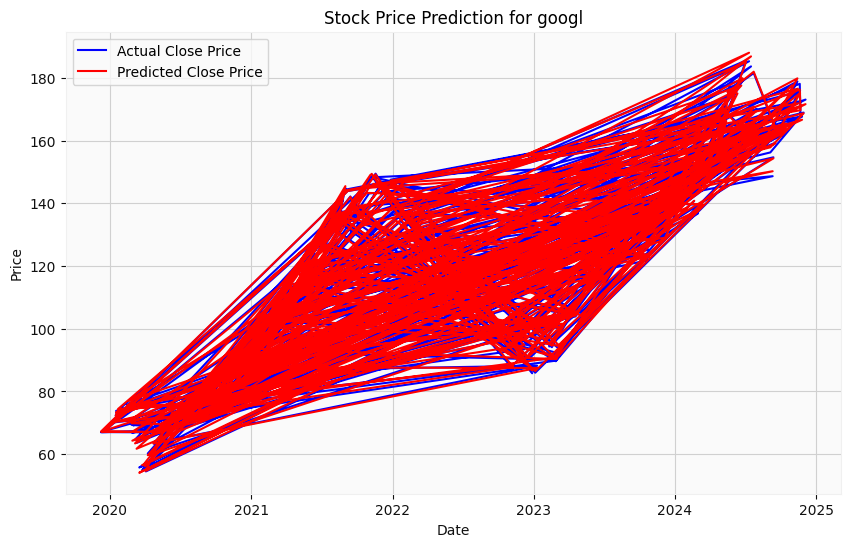

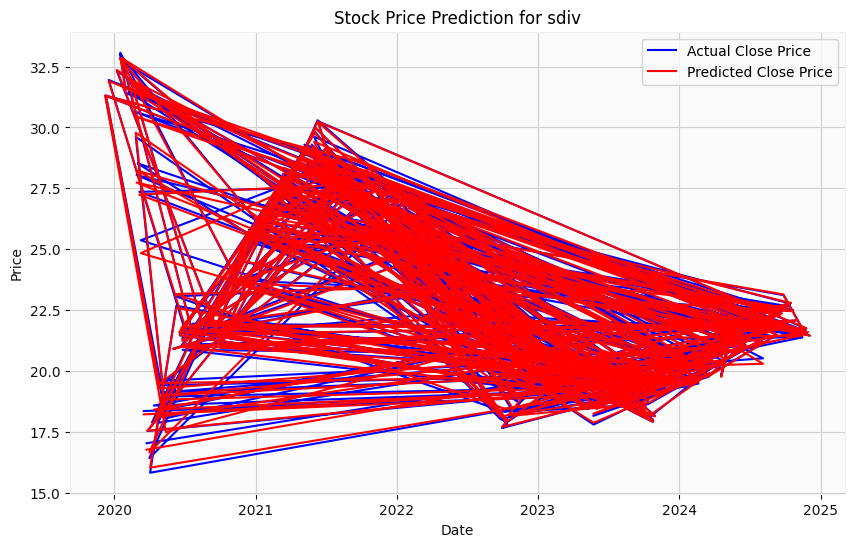

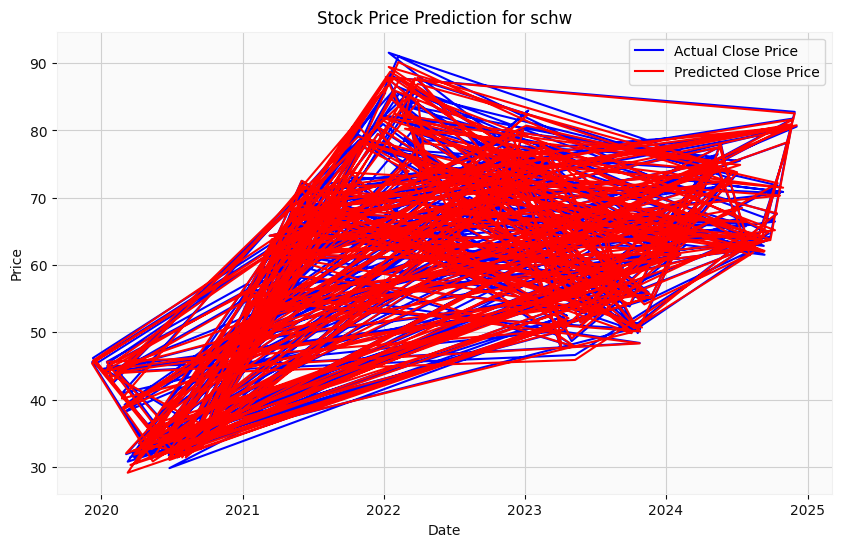

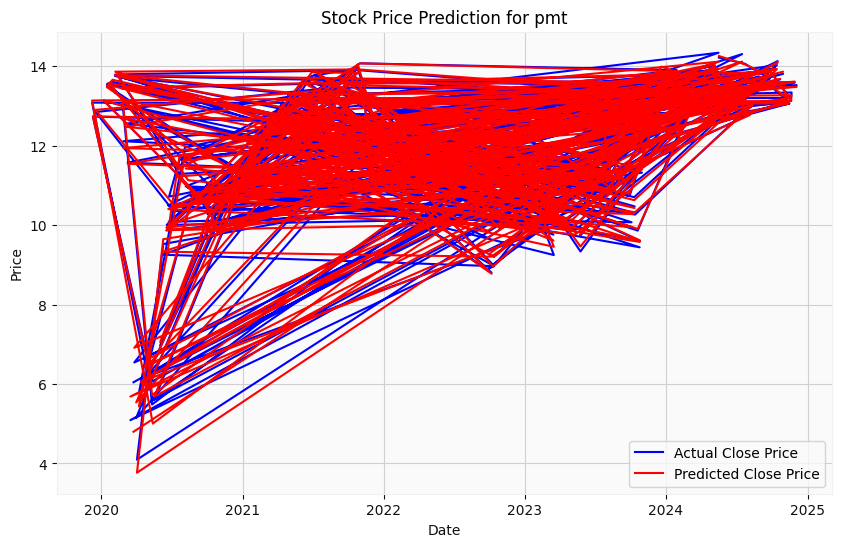

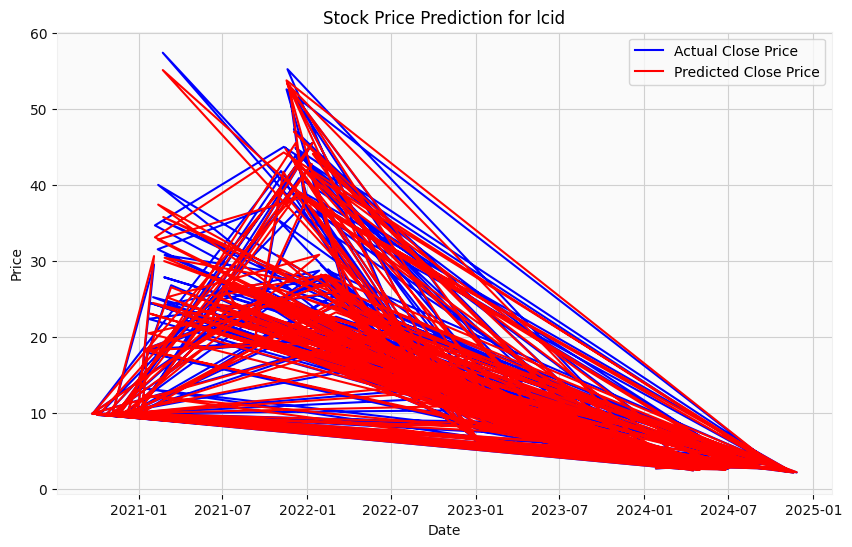

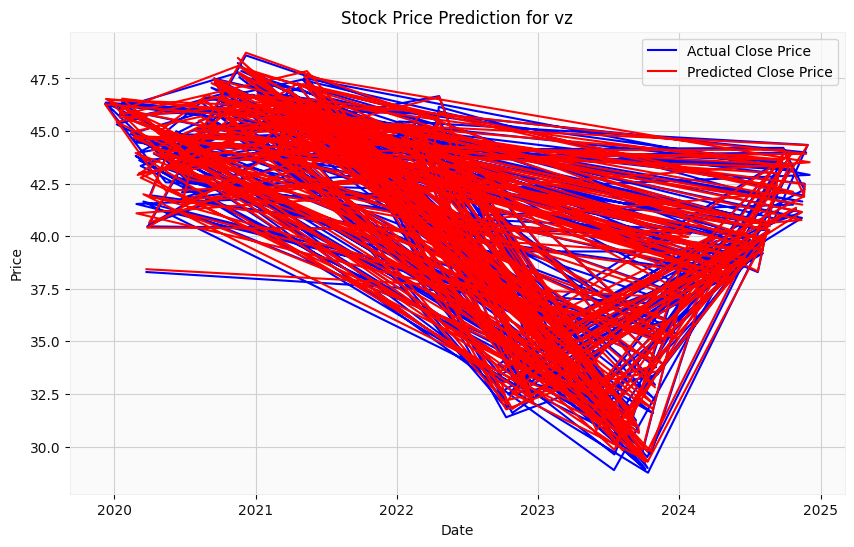

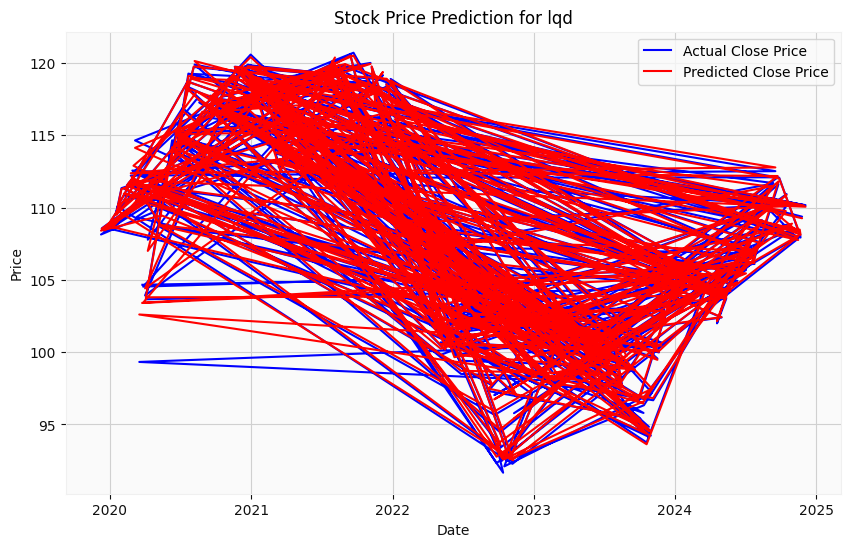

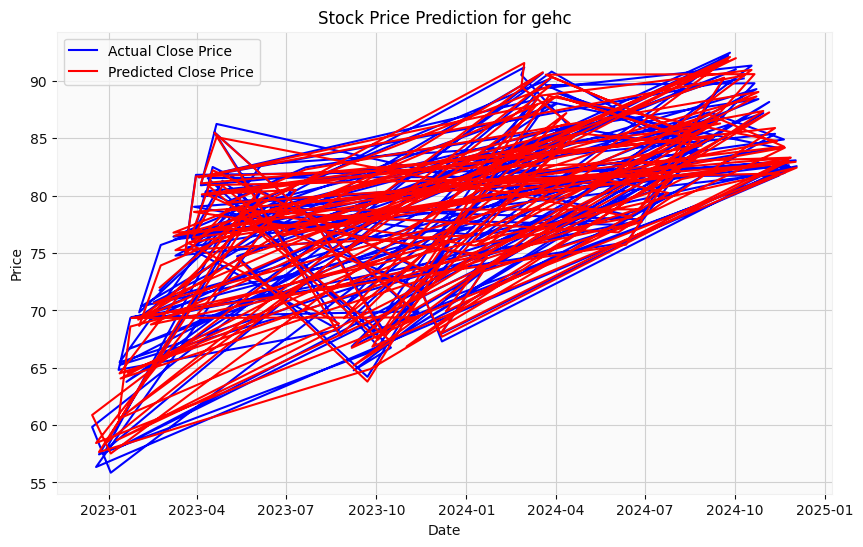

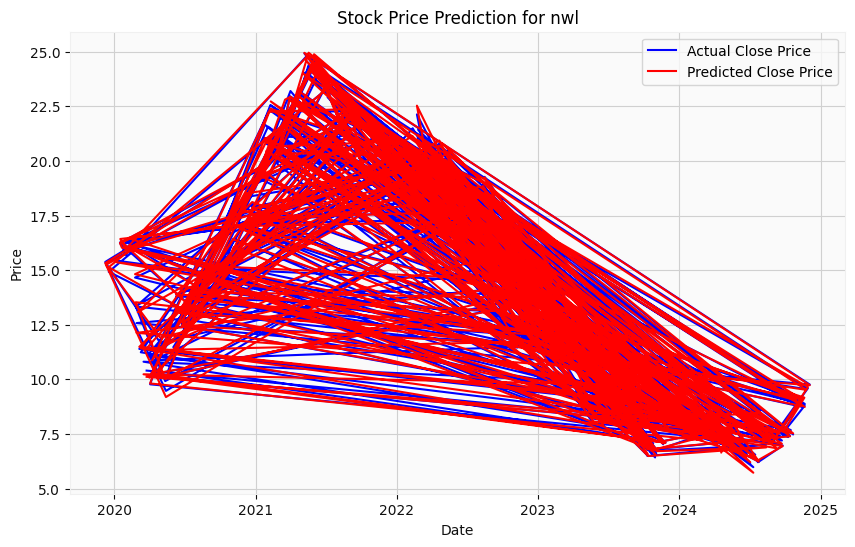

Mean Squared Error for voo: 4.677131001563496
Mean Squared Error for voog: 3.3581797769523636
Mean Squared Error for main: 0.06943837933603947
Mean Squared Error for amzn: 2.0994397627399026
Mean Squared Error for googl: 1.2303361025418147
Mean Squared Error for sdiv: 0.013724688180424131
Mean Squared Error for schw: 0.5407369650208135
Mean Squared Error for pmt: 0.019545079605584877
Mean Squared Error for lcid: 0.42357272376997984
Mean Squared Error for vz: 0.0652330867315781
Mean Squared Error for lqd: 0.09716032921275496
Mean Squared Error for gehc: 0.7050196191783461
Mean Squared Error for nwl: 0.035313784088880217


C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\ve

   Ticker  30 Days Projection
0     voo          556.011137
1    voog          370.025205
2    main           55.425734
3    amzn          215.801406
4   googl          172.512700
5    sdiv           21.440075
6    schw           80.614620
7     pmt           13.526079
8    lcid            2.100000
9      vz           43.108032
10    lqd          110.120582
11   gehc           82.973568
12    nwl            9.756347


C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
# Machine Learning 15, 30, 60 day Prdictions randon forest

import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Read stock_data.csv into DataFrame
df = pd.read_csv('stock_data.csv')

# Extract tickers from the 'Ticker' column
tickers = df['Ticker']

# List to store data for all tickers
tickers_data = []

# List to store MSE for each ticker
mse_list = []

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)

    # Get historical market data for the past month
    hist = ticker.history(period="60mo")

    # Append the historical data to the list
    tickers_data.append(hist)

    # Select relevant features and target variable
    features = ['Open', 'High', 'Low'] #, 'Volume']  # You can modify these features as needed
    
    # Drop rows with missing values
    hist = hist.dropna()

    # Split the data into features (X) and target variable (y)
    X = hist[features]
    y = hist['Close']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a Random Forest regressor
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    predictions = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mse_list.append(mse)

    # Plot predicted vs. actual prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Close Price', color='blue')
    plt.plot(y_test.index, predictions, label='Predicted Close Price', color='red')
    plt.title(f'Stock Price Prediction for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Print MSE for each ticker
for ticker_symbol, mse in zip(tickers, mse_list):
    print(f'Mean Squared Error for {ticker_symbol}: {mse}')

projected_prices = []

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)
    
    # Get historical market data for the past 24 months
    hist = ticker.history(period="60mo")
    
    # Select relevant features
    features = ['Open', 'High', 'Low'] #, 'Volume']  # You can modify these features as needed
    
    # Drop rows with missing values
    hist = hist.dropna()
    
    # Split the data into features (X) and target variable (y)
    X = hist[features]
    y = hist['Close']
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train a Random Forest regressor
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_scaled, y)
    
    # Get the most recent date in the historical data
    most_recent_date = hist.index[-1]
    
    # Projected date for 30 days in the future
    future_date = most_recent_date + timedelta(days=30)
    
    # Create features for the future date
    future_features = hist.loc[most_recent_date][features]
    
    # Standardize the features using the same scaler
    future_features_scaled = scaler.transform([future_features])
    
    # Predict the price for the future date
    future_price = model.predict(future_features_scaled)[0]
    
    # Store the projected price for the current ticker
    projected_prices.append({
        'Ticker': ticker_symbol,
        '30 Days Projection': future_price
    })

# Create a DataFrame from the projected prices
projected_prices_df = pd.DataFrame(projected_prices)

# Print the projected prices table
print(projected_prices_df)

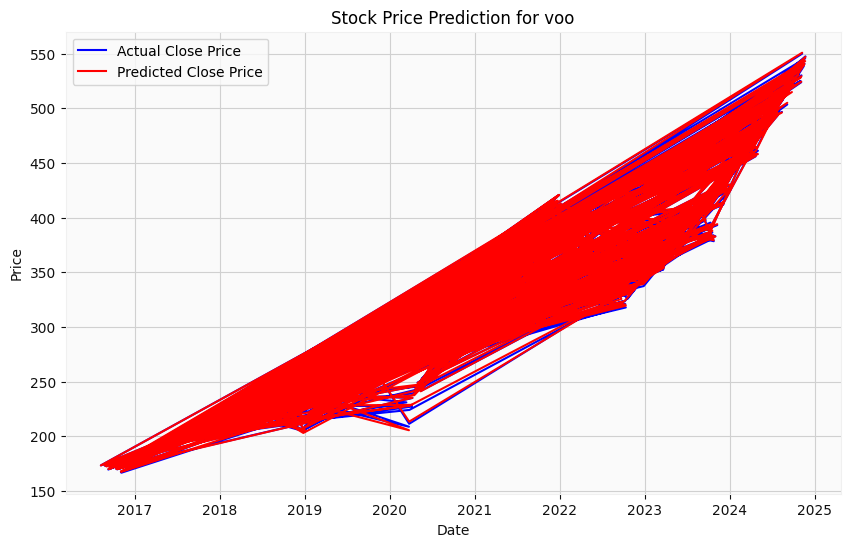

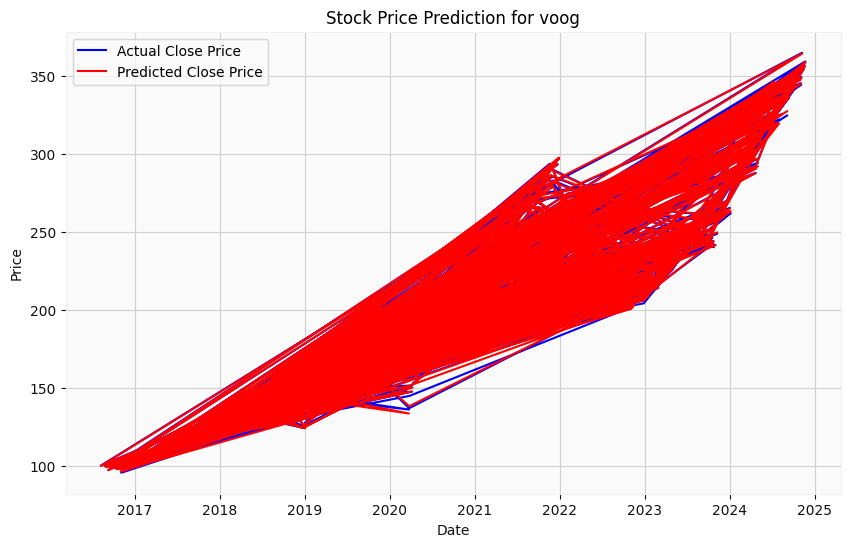

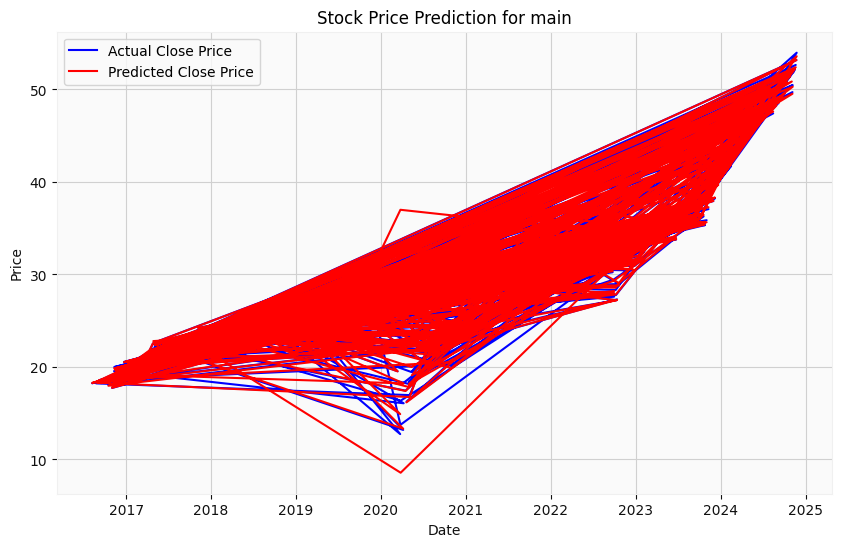

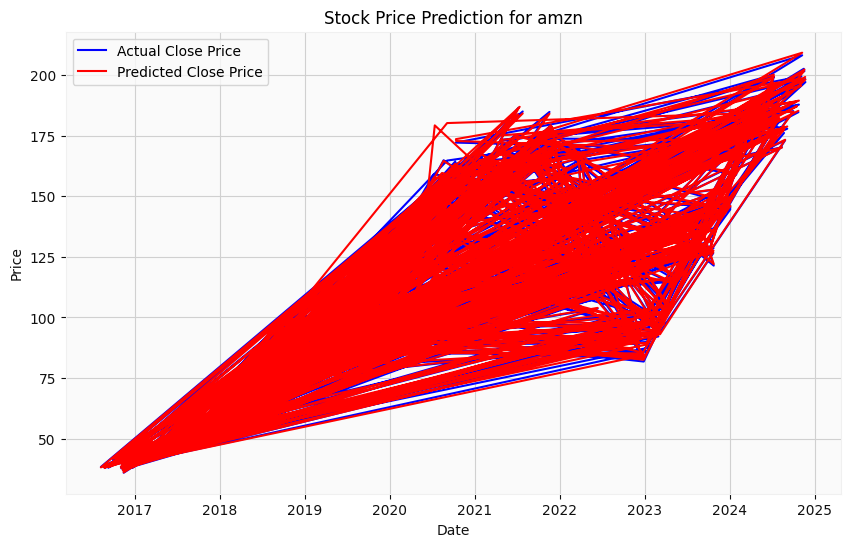

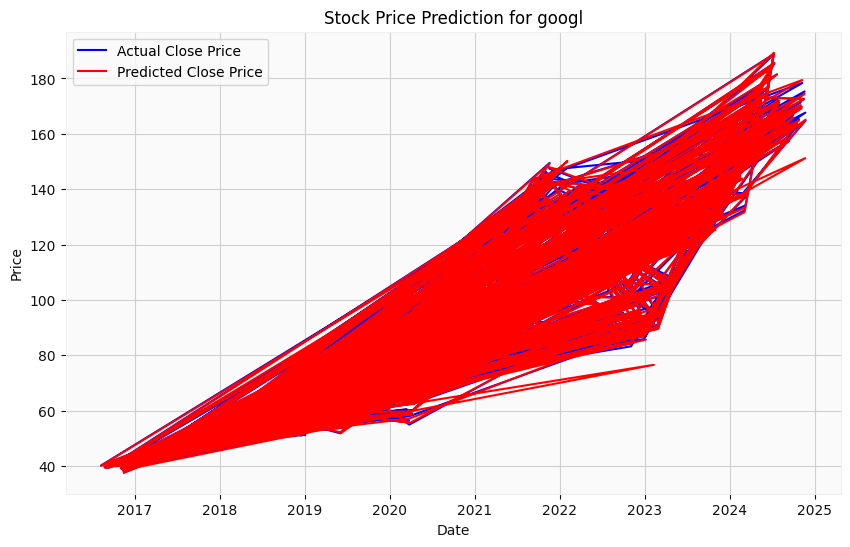

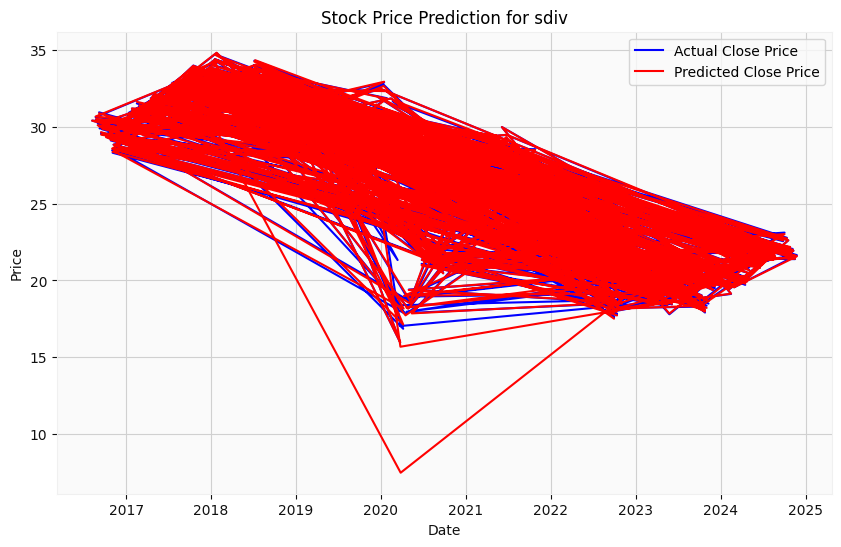

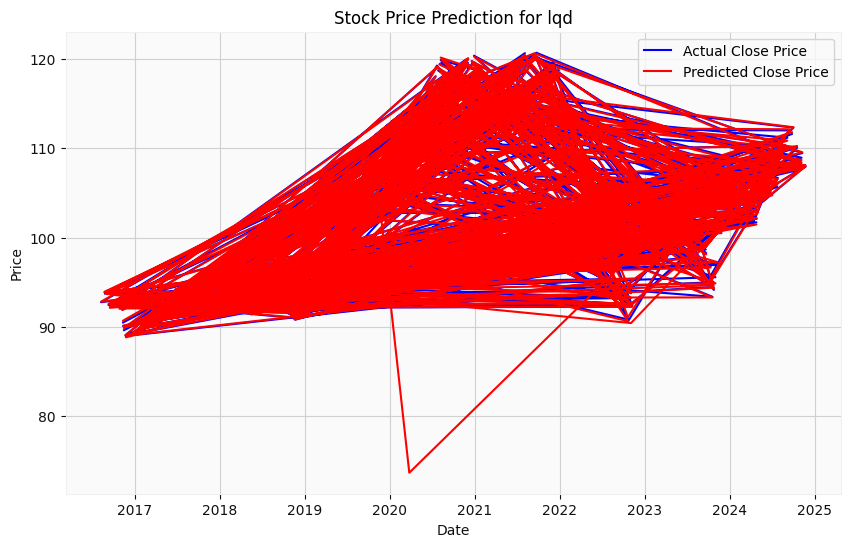

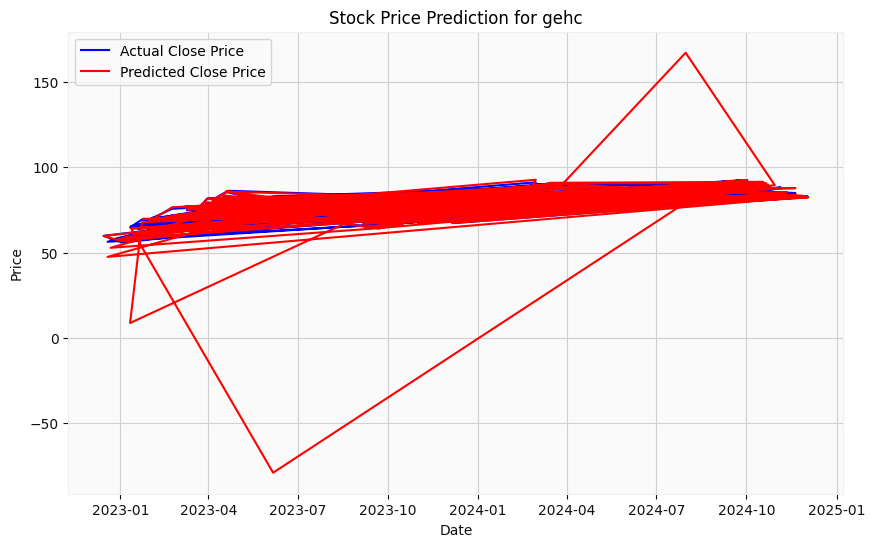

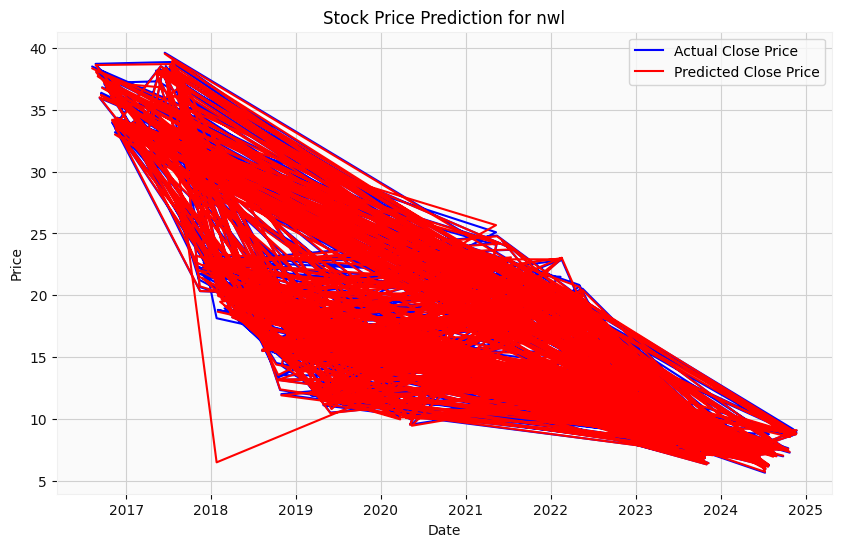

Mean Squared Error for voo: 4.211447582577298
Mean Squared Error for voog: 0.9894319042238214
Mean Squared Error for main: 1.0629834675880725
Mean Squared Error for amzn: 2.0204054517560746
Mean Squared Error for googl: 2.4138527530193987
Mean Squared Error for sdiv: 0.22004538854814618
Mean Squared Error for schw: 0.27796065780758145
Mean Squared Error for pmt: 10.020823121082126
Mean Squared Error for lcid: 851.922206129783
Mean Squared Error for vz: 0.03780283085774849
Mean Squared Error for lqd: 1.608703165369973
Mean Squared Error for gehc: 244.2917836393275
Mean Squared Error for nwl: 0.2458530292337808


C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\benja\Documents\Jupyter\ve

   Ticker  30 Days Projection
0     voo          556.501062
1    voog          371.607564
2    main           55.543522
3    amzn          218.318341
4   googl          172.482678
5    sdiv           21.510254
6    schw           80.586951
7     pmt           13.560508
8    lcid            2.127336
9      vz           43.021151
10    lqd          110.049606
11   gehc           83.065345
12    nwl            9.794217


In [8]:
# Machine Learning 15, 30, 60 day Predictions using Polynomial Regression

import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Read stock_data.csv into DataFrame
df = pd.read_csv('stock_data.csv')

# Extract tickers from the 'Ticker' column
tickers = df['Ticker']

# List to store data for all tickers
tickers_data = []

# List to store MSE for each ticker
mse_list = []

# Degree of polynomial for regression
degree = 4  # You can change the degree as needed

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)

    # Get historical market data for the past 60 months (5 years)
    hist = ticker.history(period="100mo")

    # Append the historical data to the list
    tickers_data.append(hist)

    # Select relevant features and target variable
    features = ['Open', 'High', 'Low', 'Volume']  # Historical Price Data and Volume
    
    # Drop rows with missing values
    hist = hist.dropna()

    # Split the data into features (X) and target variable (y)
    X = hist[features]
    y = hist['Close']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform features to polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train a Linear Regression model with polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions
    predictions = model.predict(X_test_poly)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mse_list.append(mse)

    # Plot predicted vs. actual prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test.values, label='Actual Close Price', color='blue')
    plt.plot(y_test.index, predictions, label='Predicted Close Price', color='red')
    plt.title(f'Stock Price Prediction for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Print MSE for each ticker
for ticker_symbol, mse in zip(tickers, mse_list):
    print(f'Mean Squared Error for {ticker_symbol}: {mse}')

projected_prices = []

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)

    # Get historical market data for the past 60 months (5 years)
    hist = ticker.history(period="60mo")

    # Select relevant features
    features = ['Open', 'High', 'Low', 'Volume']  # Historical Price Data and Volume

    # Drop rows with missing values
    hist = hist.dropna()

    # Transform features to polynomial features
    X = hist[features]
    y = hist['Close']
    X_scaled = scaler.transform(X)
    X_poly = poly.transform(X_scaled)

    # Train a Linear Regression model with polynomial features on the entire dataset
    model = LinearRegression()
    model.fit(X_poly, y)

    # Get the most recent date in the historical data
    most_recent_date = hist.index[-1]

    # Projected date for 30 days in the future
    future_date = most_recent_date + timedelta(days=30)

    # Create features for the future date
    future_features = hist.loc[most_recent_date][features]
    future_features_scaled = scaler.transform([future_features])
    future_features_poly = poly.transform(future_features_scaled)

    # Predict the price for the future date
    future_price = model.predict(future_features_poly)[0]

    # Store the projected price for the current ticker
    projected_prices.append({
        'Ticker': ticker_symbol,
        '30 Days Projection': future_price
    })

# Create a DataFrame from the projected prices
projected_prices_df = pd.DataFrame(projected_prices)

# Print the projected prices table
print(projected_prices_df)


In [9]:
import yfinance as yf
import pandas as pd

# Read stock_data.csv into DataFrame
df = pd.read_csv('stock_data.csv')

# Extract tickers from the 'Ticker' column
tickers = df['Ticker']

# List to store data for all tickers
tickers_data = []

# Iterate through each ticker symbol
for ticker_symbol in tickers:
    # Create a Ticker instance for the current stock
    ticker = yf.Ticker(ticker_symbol)
    
    # Get historical market data for the past month
    hist = ticker.history(period="24mo") 
    
    # Append the historical data to the list
    tickers_data.append(hist)

# Concatenate data for all tickers into a single DataFrame
all_tickers_data = pd.concat(tickers_data)

# Print the head of the DataFrame
#print(all_tickers_data.head())

all_tickers_data.describe ()

Open         High          Low        Close        Volume  \
count  6531.000000  6531.000000  6531.000000  6531.000000  6.531000e+03   
mean    104.903195   105.660262   104.132979   104.935627  1.433084e+07   
std     122.274371   122.852980   121.644551   122.306740  1.927685e+07   
min       2.020000     2.065000     1.930000     2.010000  2.220000e+04   
25%      19.319184    19.412666    19.220754    19.340959  5.369000e+05   
50%      63.691638    64.427562    62.994028    63.691639  5.381400e+06   
75%     130.997819   132.387193   129.554200   131.140266  2.269565e+07   
max     556.830017   557.309998   556.190125   556.879883  2.144040e+08   

         Dividends  Stock Splits  Capital Gains  
count  6531.000000   6531.000000         2012.0  
mean      0.007886      0.000051            0.0  
std       0.074166      0.004125            0.0  
min       0.000000      0.000000            0.0  
25%       0.000000      0.000000            0.0  
50%       0.000000      0.000000            0.0  
75%       0.000000      0.000000            0.0  
max       1.801000      0.333333            0.0